In [1]:
import numpy as np
import pandas as pd

In [2]:
rho_tank=4500 #kg/m3
m=4/86400#ton/s
P=410#bar
T=273.15+25
T1=T
Tref=10+273.15
Po=31

In [3]:
import pandas as pd
crit=pd.DataFrame()
crit['Comp']=['H2']
crit['Tc']=[32.938]
crit['Pc']=[1293.00]
crit['w']=[-0.2160]
crit['PM']=[1.00784*2]
T=298
#P1=100
def PRv2(Tc,Pc,mm,w,T,P):
    #Unidades: P, Pc: kPa, T, Tc: K, w: Adim, mm: kg/kmol
    R=8.314#J/mol-K
    Ru=R/mm
    mi=0.379642+1.48503*w-0.164423*w**2+0.016666*w**3
    alpha=(1+mi*(1-(T/Tc)**0.5))**2
    a=0.45724*((Ru)**2)*(Tc**2)*alpha/(Pc)
    b=0.0778*(Ru)*(Tc/Pc)
    A_may=a*P/(((Ru)**2)*(T**2))
    B_may=b*P/((Ru)*T)
    m=-(1-B_may)
    n=(A_may-(3*B_may**2)-(2*B_may))
    o=-((A_may*B_may)-(B_may**2)-(B_may**3))
    v=(Ru*T)/P
    return {'alpha':alpha,'a':a,'b':b,'A':A_may,'B':B_may,'m':m,'n':n,'o':o,'v':v}
resul_peng=PRv2(crit['Tc'][0],crit['Pc'][0],crit['PM'][0],crit['w'][0],316+273.15,172.37*100)
z=np.real(max(np.roots([1,resul_peng['m'],resul_peng['n'],resul_peng['o']])))
#r1=(P1*crit['PM'][0])/(z*(8.314)*(T+273.15))
#V1=m/r1
#V1

In [4]:
import numpy as np
from scipy.optimize import root
def trabajo_reversible(m, P1, P2, eta, T2,T1):
    P1=P1*100
    P2=P2*100
    
    resul_peng=PRv2(crit['Tc'][0],crit['Pc'][0],crit['PM'][0],crit['w'][0],T1,P1)
    z=np.real(max(np.roots([1,resul_peng['m'],resul_peng['n'],resul_peng['o']])))
    r1=(P1*crit['PM'][0])/(z*(8.314)*T1)
    
    V1=1/r1
    resul_peng=PRv2(crit['Tc'][0],crit['Pc'][0],crit['PM'][0],crit['w'][0],T2+273.15,P2)
    z=np.real(max(np.roots([1,resul_peng['m'],resul_peng['n'],resul_peng['o']])))
    r2=(P2*crit['PM'][0])/(z*(8.314)*(T2+273.15))
    V2=1/r2
    n = np.log(P2/P1)/(np.log((V1)/(V2)))
    
    term1 = (m * P1 * 1000 * V1) / (0.72*(n - 1)/n)
    term2 = (P2 / P1) ** ((n - 1) / n) - 1
    W_rev=term1*term2/1000
    return W_rev/eta

def trabajo_reversible_IT(tt, m, P1, P2, eta,T1):
    P1=P1*100
    P2=P2*100
    T2=abs(tt[0])

    resul_peng=PRv2(crit['Tc'][0],crit['Pc'][0],crit['PM'][0],crit['w'][0],T1,P1)
    z=np.real(max(np.roots([1,resul_peng['m'],resul_peng['n'],resul_peng['o']])))
    r1=(P1*crit['PM'][0])/(z*(8.314)*T1)

    V1=1/r1
    resul_peng=PRv2(crit['Tc'][0],crit['Pc'][0],crit['PM'][0],crit['w'][0],T2,P2)
    z=np.real(max(np.roots([1,resul_peng['m'],resul_peng['n'],resul_peng['o']])))
    r2=(P2*crit['PM'][0])/(z*(8.314)*(T2))
    V2=1/r2
    n = np.log(P2/P1)/(np.log((V1)/(V2)))
    
    term1 = (1 * P1 * V1 * 1000) / (0.72*(n - 1)/n)
    term2 = (P2 / P1) ** ((n - 1) / n) - 1
    Tref=T1
    T=T2
    HhH2=(19.67099783*(T-Tref) + 0.069681519/2*(T**2-Tref**2) - 0.000200098/3*(T**3-Tref**3) + 2.89493E-07/4*(T**4-Tref*4) - 2.22475E-10/5*(T**5-Tref**5) + 8.81466E-14/6*(T**6-Tref**6) - 1.42043E-17/7*(T**6-Tref**6))/2
    HhH2=HhH2
    T=T1
    HhH1=(19.67099783*(T-Tref) + 0.069681519/2*(T**2-Tref**2) - 0.000200098/3*(T**3-Tref**3) + 2.89493E-07/4*(T**4-Tref*4) - 2.22475E-10/5*(T**5-Tref**5) + 8.81466E-14/6*(T**6-Tref**6) - 1.42043E-17/7*(T**6-Tref**6))/2
    HhH1=HhH1
    W_rev=term1*term2/1000
    print('kW',W_rev)
    return W_rev - (HhH2 - HhH1)

P1=31
P2=141.82
m=m
eta=0.75
sol = root(trabajo_reversible_IT, x0=500, args=(m, P1, P2, eta,298.15), method='hybr')
if sol.success:
    print(sol.message)
else:
    print(sol.message)

resultado = trabajo_reversible(m, P1, P2, eta, sol.x[0]-273.15,298.15)
print(f"W: {resultado:.20f} kW")
sol.x-273.15

kW 3496.8473861408834
kW 3496.8473861408834
kW 3496.8473861408834
kW 3496.84741376228
kW 3677.64368506432
kW 3676.072128824285
kW 3676.08623771237
kW 3676.086238880761
The solution converged.
W: 0.22691890363461486579 kW


array([275.93059926])

In [5]:
Tref

283.15

In [6]:
import numpy as np
from scipy.optimize import root

def balance(x, T, Tref, m):
    global e
    global s
    """
    Calcula la función de balance para el proceso,
    devolviendo la diferencia e - s.

    Parámetros:
      x    : vector de incógnitas; se asume que x[0] es la variable a encontrar.
      T    : temperatura en K.
      Tref : temperatura de referencia en K.
      m    : masa del hidrógeno (kg).

    La función utiliza dos series polinómicas (para H2 y H2O)
    para calcular, respectivamente, las energías 'e' y 's', y retorna e - s.
    """
    # Calcular la entalpía (u otra propiedad) para hidrógeno
    Ta=15+273.15
    Ts=92+273.15
    HhH2 = ( 19.67099783*(T - Tref)
              + (0.069681519/2) * (T**2 - Tref**2)
              - (0.000200098/3) * (T**3 - Tref**3)
              + (2.89493E-07/4) * (T**4 - Tref**4)
              - (2.22475E-10/5) * (T**5 - Tref**5)
              + (8.81466E-14/6) * (T**6 - Tref**6)
              - (1.42043E-17/7) * (T**7 - Tref**7)
            ) / 2
    

    # Calcular la entalpía (u otra propiedad) para agua (H2O)
    HhH2O = ( -22.41701677*(Ta - Tref)
               + (0.876972156/2) * (Ta**2 - Tref**2)
               - (0.002570393/3) * (Ta**3 - Tref**3)
               + (2.48383E-06/4) * (Ta**4 - Tref**4)
             ) / 18.015
    Tk=25+273.15
    HhH22 = ( 19.67099783*(Tk - Tref)
              + (0.069681519/2) * (Tk**2 - Tref**2)
              - (0.000200098/3) * (Tk**3 - Tref**3)
              + (2.89493E-07/4) * (Tk**4 - Tref**4)
              - (2.22475E-10/5) * (Tk**5 - Tref**5)
              + (8.81466E-14/6) * (Tk**6 - Tref**6)
              - (1.42043E-17/7) * (Tk**7 - Tref**7)
            ) / 2
    

    # Calcular la entalpía (u otra propiedad) para agua (H2O)
    HhH2O2 = ( -22.41701677*(Ts - Tref)
               + (0.876972156/2) * (Ts**2 - Tref**2)
               - (0.002570393/3) * (Ts**3 - Tref**3)
               + (2.48383E-06/4) * (Ts**4 - Tref**4)
             ) / 18.015
    m=m*1e3
    s = (HhH22 + HhH2O2)* x[0]
    e = (HhH2 + HhH2O) * m
    
    return e - s


In [7]:

import pandas as pd
import math

class PriceCalculator:
    def __init__(self, dataframe,spares,material):
        self.dataframe = dataframe
        self.spares = spares
        self.material = material
        self.calculate_price()

    def calculate_price(self):
        prices = []
        cepci_2001 = 397
        cepci_2024 = 798.8
        k1=2.2897
        k2=1.3604
        k3=-0.1027
        if self.material == "Carbon Steel":
            sFBM=3.4
        elif self.material == "Stainless Steel":
            sFBM=7.0
        else:
            sFBM=13.9 #for Nickel Alloy
        FBMCS=3.4 #for Carbon Steel

        for index, row in self.dataframe.iterrows():
            if index < len(self.dataframe) - 1:  # For all rows except the last one
                w_value = row["W (kW)"]
                A = k1+(k2*math.log10(w_value))+(k3*(math.log10(w_value)**2))
                B=(10**A)*(self.spares+1)/cepci_2001*cepci_2024
                price=B*sFBM/FBMCS
                prices.append(price)
            else:  # For the last row
                total_price = sum(prices)
                prices.append(total_price)
        self.dataframe["Purchased Equipment Cost (USD)"] = prices
        self.dataframe["Purchased Equipment Cost (USD)"] = self.dataframe["Purchased Equipment Cost (USD)"].apply(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
        self.total_price = prices[-1]  # Total price is the last value in the list
        installation_cost = total_price * 2.5
        piping_cost = self.total_price * 0.21
        electrical_cost = self.total_price * 0.16
        instrumentation_cost = self.total_price * 0.08
        Final_cost = self.total_price + piping_cost + electrical_cost + instrumentation_cost+installation_cost
        cost_mxn= Final_cost * 19.59 
        pricce_mxn=self.total_price*19.59


        # Create a data frame with the extra costs
        extras = {
            "Purchased Equipment Cost (USD)": [self.total_price],
            "Purchased Equipment Cost (MXN)": [pricce_mxn],
            "Installation Cost (USD)": [installation_cost],
            "Piping Cost (USD)": [piping_cost],
            "Electrical Cost (USD)": [electrical_cost],
            "Instrumentation Cost (USD)": [instrumentation_cost],
            "Final Cost (USD)": [Final_cost],
            "Final Cost (MXN)": [cost_mxn]
            
        }
        self.extras_df = pd.DataFrame(extras)
        # Format the numbers in the extras_df as currency
        self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
        self.final=Final_cost
        return self.dataframe, self.extras_df

# Use the class with the prueba dataframe
SS="Stainless Steel"
CS="Carbon Steel"
NA="Nickel Alloy"



In [8]:
import numpy as np
from scipy.optimize import root

def calcular_dimension_tanque(P, m, crit, tipo, rho_tank, T=300, x0=[1, 1]):
    """
    Calcula las dimensiones, espesor y masa de un tanque en base a parámetros de entrada.
    
    Parámetros:
      - P: Presión de entrada (se espera en unidades que requieran ser convertidas a Pascales).
      - m: Masa (kg) o cantidad similar requerida para el cálculo del volumen.
      - crit: Diccionario con las propiedades críticas, debe incluir las claves:
              'Tc', 'Pc', 'PM' y 'w'. Se usan los primeros elementos (ej: crit['Tc'][0]).
      - tipo: Tipo de tanque, str. Debe ser 'hemi' o 'semi'.
      - rho_tank: Densidad del material del tanque (kg/m³).
      - T: Temperatura en Kelvin (por defecto 300 K).
      - x0: Valor inicial para la solución del sistema [r, L] (por defecto [1.5, 3.0]).
      
    Retorna:
      Un diccionario con los siguientes valores:
        - 'volumen_total': Volumen calculado del tanque (m³).
        - 'radio': Radio del tanque (m).
        - 'longitud': Longitud del tanque (m).
        - 'espesor': Espesor del tanque (m).
        - 'masa': Masa del tanque (ton).
        - 'V_objetivo': Volumen objetivo calculado (m³).
    
    Se lanzará un ValueError en caso de que el sistema no encuentre solución o 
    si el tipo de tanque no es reconocido.
    """
    
    # Se recalcula V_objetivo usando el método de Peng–Robinson (se asume PRv2 está definida)
    resul_peng = PRv2(crit['Tc'][0], crit['Pc'][0], crit['PM'][0], crit['w'][0], T, (P)*100)
    z = np.real(max(np.roots([1, resul_peng['m'], resul_peng['n'], resul_peng['o']])))
    r1 = (100 * P1 * crit['PM'][0]) / (z * 8.314 * T)
    V1 = m / r1
    V_objetivo = V1

    # Definición del sistema de ecuaciones para resolver por el método root
    def ecuaciones(x, V_obj):
        r, L = abs(x[0]), abs(x[1])
        if tipo == 'hemi':
            V_tank = (4 / 3) * np.pi * r**3 + (L - 2*r) * np.pi * r**2
        elif tipo == 'semi':
            V_tank = np.pi * r**2 * L + (2/3) * np.pi * r**3
        else:
            raise ValueError("Tipo de tanque no reconocido. Usa 'hemi' o 'semi'.")
        
        f1 = V_tank - V_obj  # La diferencia entre el volumen calculado y el objetivo
        f2 = L - 4 * r     # Relación de diseño entre L y r
        return [f1, f2]

    # Resolver el sistema de ecuaciones
    solucion = root(
    ecuaciones, 
    x0=x0, 
    args=(V_objetivo,), 
    method='hybr', 
    tol=1e-3, 
    options={'maxfev': 10000000}  # limite máximo de evaluaciones (iteraciones)
)

    if not solucion.success:
        raise ValueError("No se encontró solución: " + solucion.message)
    
    r, L_encontrado = solucion.x[0], solucion.x[1]

    # Calcular el volumen total del tanque según el tipo
    if tipo == 'hemi':
        V_total_sol = (4 / 3) * np.pi * r**3 + (L_encontrado - 2*r) * np.pi * r**2
    elif tipo == 'semi':
        V_total_sol = (2 / 3) * np.pi * r**3 + (L_encontrado - r) * np.pi * r**2
    else:
        raise ValueError("Tipo de tanque no reconocido. Usa 'hemi' o 'semi'.")

    # Cálculo del espesor del tanque usando una ecuación de pared delgada
    FS = 1.5  # Factor de seguridad
    Sy = 2811 * 100000
    Su = 3095 * 100000
    t1 = (100000*P * r * FS) / Sy
    t2 = (100000*P * r * 2.25) / Su
    t = max(t1, t2)  # Espesor del tanque (en metros)

    # Para el cálculo de la masa se asume h = r
    h = r
    if tipo == 'hemi':
        mt = rho_tank * ((4/3) * np.pi * (r + t)**3 + np.pi * (r + t)**2 * L_encontrado - V_objetivo)
    elif tipo == 'semi':
        mt = rho_tank * (np.pi * ((r + t)**2 * L_encontrado + (2/3) * (r + t)**2 * (h + t)) -
                         (np.pi * r**2 * L_encontrado + (2/3) * np.pi * r**2 * h))
    else:
        raise ValueError("Tipo de tanque no reconocido. Usa 'hemi' o 'semi'.")
    mt = mt / 1000  # Conversión a toneladas

    # Impresión de resultados
    print("Volumen calculado del tanque:", round(V_total_sol, 2), "m³")
    print("Radio del tanque:", round(r, 2), "m")
    print("Longitud del tanque:", round(L_encontrado, 2), "m")
    print("Espesor del tanque:", round(t*1000, 2), "mm")
    print("Masa del tanque:", round(mt, 2), "ton")

    # Retorna los resultados en un diccionario
    return {
        'volumen_total': V_total_sol,
        'radio': r,
        'longitud': L_encontrado,
        'espesor': t,
        'masa': mt,
        'V_objetivo': V_objetivo,
        'h2':m
    }

# Ejemplo de uso:
# Se debe definir o importar la función PRv2 y el diccionario crit apropiadamente.

import pandas as pd
crit=pd.DataFrame()
crit['Comp']=['H2']
crit['Tc']=[32.938]
crit['Pc']=[1293.00]
crit['w']=[-0.2160]
crit['PM']=[1.00784*2]

class TankCostCalculator:
    price_per_lb_gas = {
        "Type I": 5.5,
        "Type II": 9.0,
        "Type III & IV": 15.5
    }

    def __init__(self, tank_type, gas_mass_kg):
        self.tank_type = tank_type
        self.gas_mass_kg = gas_mass_kg
        self.gas_mass_lb = gas_mass_kg * 2.20462  # in lb
        self.price_per_lb = self.price_per_lb_gas[tank_type]
        self.extras_df = self.calculate_cost()  # Call calculate_cost during initialization

    def calculate_cost(self):
        CEPCI_2014 = 576.1
        CEPCI_2024 = 798.8
        self.price= (self.gas_mass_lb * self.price_per_lb)* (CEPCI_2024 / CEPCI_2014)
        self.total_material_cost= self.price * 1.2  
        self.construction= self.price * 0.08
        installation_cost = self.price * 2.5
        instrumentation_cost = self.price * 0.08
        Final_cost = self.price + self.total_material_cost + self.construction + installation_cost + instrumentation_cost
        cost_mxn= Final_cost * 19.61  
        self.final=Final_cost
        # Create a data frame with the extra costs
        extras = {
            "Total Price (FOB)": [self.price],
            "Installation Cost (USD)": [installation_cost],
            "Total Material Cost (USD)": [self.total_material_cost],
            "Construction Cost (USD)": [self.construction],
            "Instrumentation Cost (USD)": [instrumentation_cost],
            "Final Cost (USD)": [Final_cost],
            "Final Cost (MXN)": [cost_mxn]
        }
        self.extras_df = pd.DataFrame(extras)
        # Format the numbers in the extras_df as currency
        self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)       
        return  self.extras_df


T1="Type I"
T2="Type II"
T3="Type III & IV"



In [9]:
Pes=list(np.linspace(110,800))

In [10]:
m

4.6296296296296294e-05

In [11]:
Tref=283.15

In [12]:
import pandas as pd
import numpy as np
from scipy.optimize import root

# Inicialización de listas y acumulador de resultados
stages = []
temperature = []
compis = []
Qk = []
Wk = []
waterr = []
price_list = []
resultados_list = []  # Aquí se guardarán los diccionarios con los resultados de cada iteración

for i in range(len(Pes)):
    # Configuración inicial por cada presión en Pes
    P = Pes[i]
    Po = 31
    P_diff = P - Po
    P1_inicial = Po
    P2_target = P
    
    # Cálculo del número de etapas
    N_etapas = np.ceil((np.log(P2_target) / np.log(Po)) / np.log(2))
    stages.append(N_etapas)
    
    P_etapa = P_diff / N_etapas
    P_acum = [Po]
    Temps = [25 + 273.15]
    
    # Inicialización de contenedores para los datos de cada etapa
    Qs, Ts, m_H2O, comp, power, Ps = [], [], [], [], [], []
    Tcomp = []  # Lista para almacenar el valor de "T comp" en cada etapa
    eta = 0.75
    Tref_val = Tref  # Se asume que Tref ya está definida

    # Cálculos para cada etapa (se usa j para evitar conflicto con i)
    for j in range(int(N_etapas)):
        P1 = sum(P_acum)
        P_acum.append(P_etapa)
        P2 = sum(P_acum)
        
        print(f"P1: {P1}, P2: {P2}, eta: {eta}, m: {m}")
        # Resolver para el trabajo reversible utilizando root
        x0 = [1.0]
        sol = root(trabajo_reversible_IT, x0=[500], args=(m, P1, P2, eta, 298.15), method='hybr')
        if sol.success:
            print(sol.message)
        else:
            print(sol.message)
        
        # Cálculo del trabajo y otros parámetros
        tkñ = sol.x[0]  # Valor obtenido para T2 (en K)
        print('kkkkkkk', tkñ)
        resultado = trabajo_reversible(m, P1, P2, eta, tkñ - 273.15, 298.15)
        print(f"W: {resultado:.20f} kW")
        
        # Resolver la ecuación de balance
        solucion = root(balance, x0, args=(tkñ, Tref_val, m), method='hybr')
        if solucion.success:
            x_encontrado = solucion.x[0]
            print(f"Solución encontrada: x = {x_encontrado:.6f}")
            
            # Se actualizan los acumuladores de datos
            Temps.append(25 + 273.15)
            Qs.append(float(-e))      # Se asume que "e" está definido
            Ts.append(25 + 273.15)
            m_H2O.append(float(x_encontrado))
            comp.append('No. ' + str(j + 1))
            power.append(resultado * 1e3)
            Ps.append(P2)
            Tcomp.append(tkñ-273.15)  # Agregar el valor de tkñ a la lista para esta etapa
        else:
            print("No se encontró solución:", solucion.message)
    
    # Crear el DataFrame de compresores con los datos por etapa
    data = {
        "Compressor": comp,
        "T (K)": Ts,
        "P (bar)": Ps,  # Se asume que el valor está en bar
        "Cooling H2O (kg/s)": m_H2O,
        "Q (kW)": np.array(Qs),
        "W (kW)": np.array(power),
        "T comp": Tcomp  # Ahora se almacena la lista completa de valores por etapa
    }
    df_compresores = pd.DataFrame(data)
    
    # Agregar una fila de totales al final de df_compresores
    total_row = [
        "Total",
        Temps[-1],
        Ps[-1],
        sum(df_compresores['Cooling H2O (kg/s)']),
        sum(df_compresores['Q (kW)']),
        sum(df_compresores['W (kW)']),
        sum(df_compresores['T comp'])
    ]
    df_compresores.loc[df_compresores.shape[0]] = total_row
    compis.append(df_compresores)
    
    # Se instancia el PriceCalculator; se asume que devuelve la información requerida.
    calculator = PriceCalculator(df_compresores, N_etapas, CS)
    calculator_info = {
        "volumen_total": calculator.volumen_total if hasattr(calculator, 'volumen_total') else None,
        "radio":         calculator.radio         if hasattr(calculator, 'radio')         else None,
        "longitud":      calculator.longitud      if hasattr(calculator, 'longitud')      else None,
        "espesor":       calculator.espesor       if hasattr(calculator, 'espesor')       else None,
        "masa":          calculator.masa          if hasattr(calculator, 'masa')          else None,
        "V_objetivo":    calculator.V_objetivo    if hasattr(calculator, 'V_objetivo')    else None,
        "h2":            m  # Se utiliza el valor de m definido externamente
    }
    
    # Actualizar las listas agregadas con información del renglón "Total" de df_compresores
    tot_idx = df_compresores.shape[0] - 1
    temperature.append(df_compresores.loc[tot_idx]['T (K)'])
    Qk.append(df_compresores.loc[tot_idx]['Q (kW)'])
    Wk.append(df_compresores.loc[tot_idx]['W (kW)'])
    waterr.append(df_compresores.loc[tot_idx]['Cooling H2O (kg/s)'])
    
    # Cálculo de dimensiones del tanque y su costo
    resultadot = calcular_dimension_tanque(df_compresores.loc[tot_idx]['P (bar)'], 10000, crit, 'hemi', 4500)
    calculator1 = TankCostCalculator("Type I", resultadot['masa'] * 1e3)
    total_price = calculator.final #+ calculator1.final
    price_list.append(total_price)
    
    # Crear un diccionario que combine los datos totales y la info de calculator
    resultado_row = {
        "T (K)": df_compresores.loc[tot_idx]['T (K)'],
        "P (bar)": df_compresores.loc[tot_idx]['P (bar)'],
        "Cooling H2O (kg/s)": df_compresores.loc[tot_idx]['Cooling H2O (kg/s)'],
        "Q (kW)": df_compresores.loc[tot_idx]['Q (kW)'],
        "W (kW)": df_compresores.loc[tot_idx]['W (kW)'],
        "volumen_total": calculator_info["volumen_total"],
        "radio":         calculator_info["radio"],
        "longitud":      calculator_info["longitud"],
        "espesor":       calculator_info["espesor"],
        "masa":          calculator_info["masa"],
        "V_objetivo":    calculator_info["V_objetivo"],
        "h2":            calculator_info["h2"],
        "price":         total_price,
        "It. No.":       i
    }
    resultados_list.append(resultado_row)

# Crear el DataFrame final de resultados a partir de la lista
df_resultados = pd.DataFrame(resultados_list)
df_resultados


P1: 31, P2: 70.5, eta: 0.75, m: 4.6296296296296294e-05
kW 1867.2835333955588
kW 1867.2835333955588
kW 1867.2835333955588
kW 1867.2835483360004
kW 1692.125003213775
kW 1690.4741173340667
kW 1690.4582729397364
kW 1690.4582714369349
The solution converged.
kkkkkkk 414.38036612962935
W: 0.10434927601462562485 kW
Solución encontrada: x = 0.158417
P1: 70.5, P2: 110.0, eta: 0.75, m: 4.6296296296296294e-05
kW 1024.654754246111
kW 1024.654754246111
kW 1024.654754246111
kW 1024.654762370594
kW 862.9168037527157
kW 860.9828037583148
kW 860.9569083348937
kW 860.9569032420858
kW 860.9569032420729
The solution converged.
kkkkkkk 357.5972806605881
W: 0.05314548785444894036 kW
Solución encontrada: x = 0.090268
Volumen calculado del tanque: 1830.77 m³
Radio del tanque: 5.59 m
Longitud del tanque: 22.37 m
Espesor del tanque: 447.15 mm
Masa del tanque: 7443.47 ton
P1: 31, P2: 62.027210884353735, eta: 0.75, m: 4.6296296296296294e-05
kW 1574.1256794339677
kW 1574.1256794339677
kW 1574.1256794339677
kW 1574

/tmp/ipykernel_79139/1972708371.py:62: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_79139/1702185921.py:160: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_79139/1972708371.py:62: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_79139/1702185921.py:160: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_79139/1972708371.py:62: FutureWarning: DataFrame.applymap has been deprecated. 

kW 1003.561531812732
kW 1001.5669125566827
kW 1001.5413847204555
kW 1001.5413801802263
kW 1001.5413801802164
The solution converged.
kkkkkkk 367.24751627400195
W: 0.06182354198643311149 kW
Solución encontrada: x = 0.101824
P1: 149.38095238095235, P2: 208.57142857142853, eta: 0.75, m: 4.6296296296296294e-05
kW 793.9804257226883
kW 793.9804257226883
kW 793.9804257226883
kW 793.9804318603934
kW 658.9806556205637
kW 657.3680592963445
kW 657.345714615485
kW 657.3457098395777
kW 657.3457098395636
The solution converged.
kkkkkkk 343.59675449809396
W: 0.04057689566910886031 kW
Solución encontrada: x = 0.073528
Volumen calculado del tanque: 904.16 m³
Radio del tanque: 4.42 m
Longitud del tanque: 17.68 m
Espesor del tanque: 670.16 mm
Masa del tanque: 4892.47 ton
P1: 31, P2: 94.8843537414966, eta: 0.75, m: 4.6296296296296294e-05
kW 2552.5492349633023
kW 2552.5492349633023
kW 2552.5492349633023
kW 2552.5492553035433
kW 2461.4968612492803
kW 2461.0899700466102
kW 2461.0881641263372
kW 2461.08816409

/tmp/ipykernel_79139/1972708371.py:62: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_79139/1702185921.py:160: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_79139/1972708371.py:62: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_79139/1702185921.py:160: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_79139/1972708371.py:62: FutureWarning: DataFrame.applymap has been deprecated. 

kW 1353.822162151769
kW 1353.822162151769
kW 1353.822172569336
kW 1179.5937341931722
kW 1177.6657504259335
kW 1177.643007968612
kW 1177.643004574798
The solution converged.
kkkkkkk 379.31886990009133
W: 0.07269401262807392849 kW
Solución encontrada: x = 0.116297
P1: 233.87074829931976, P2: 335.30612244897964, eta: 0.75, m: 4.6296296296296294e-05
kW 892.1402654617007
kW 892.1402654617007
kW 892.1402654617007
kW 892.1402721114866
kW 752.5505631488719
kW 750.9486126916883
kW 750.927734398747
kW 750.927730456785
kW 750.9277304567763
The solution converged.
kkkkkkk 350.03527521318983
W: 0.04635356360844298390 kW
Solución encontrada: x = 0.081222
Volumen calculado del tanque: 614.78 m³
Radio del tanque: 3.89 m
Longitud del tanque: 15.55 m
Espesor del tanque: 947.39 mm
Masa del tanque: 4498.18 ton
P1: 31, P2: 137.1292517006803, eta: 0.75, m: 4.6296296296296294e-05
kW 3416.8009736133245
kW 3416.8009736133245
kW 3416.8009736133245
kW 3416.801000627452
kW 3566.992864133905
kW 3565.910259318798
k

/tmp/ipykernel_79139/1972708371.py:62: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_79139/1702185921.py:160: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_79139/1972708371.py:62: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_79139/1702185921.py:160: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_79139/1972708371.py:62: FutureWarning: DataFrame.applymap has been deprecated. 

Volumen calculado del tanque: 481.14 m³
Radio del tanque: 3.58 m
Longitud del tanque: 14.33 m
Espesor del tanque: 1203.05 mm
Masa del tanque: 4536.32 ton
P1: 31, P2: 179.37414965986395, eta: 0.75, m: 4.6296296296296294e-05
kW 4062.8508706567604
kW 4062.8508706567604
kW 4062.8508706567604
kW 4062.850902501064
kW 4502.720191257912
kW 4493.15268824869
kW 4493.379533593567
kW 4493.379670705594
kW 4493.379670703589
The solution converged.
kkkkkkk 603.8389257080645
W: 0.27736911547553017021 kW
Solución encontrada: x = 0.386809
P1: 179.37414965986395, P2: 327.7482993197279, eta: 0.75, m: 4.6296296296296294e-05
kW 1472.9039676663294
kW 1472.9039676663294
kW 1472.9039676663294
kW 1472.9039787096494
kW 1301.6826196789127
kW 1299.9075373986739
kW 1299.8882858086988
kW 1299.8882833981277
The solution converged.
kkkkkkk 387.68842978249506
W: 0.08024001749371156844 kW
Solución encontrada: x = 0.126341
P1: 327.7482993197279, P2: 476.1224489795918, eta: 0.75, m: 4.6296296296296294e-05
kW 967.835816696

/tmp/ipykernel_79139/1972708371.py:62: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_79139/1702185921.py:160: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_79139/1972708371.py:62: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_79139/1702185921.py:160: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_79139/1972708371.py:62: FutureWarning: DataFrame.applymap has been deprecated. 

kW 1013.6934793298029
kW 1013.6934863403312
kW 875.9655402256851
kW 874.5308287483329
kW 874.5143349080554
kW 874.5143324802165
The solution converged.
kkkkkkk 358.5284706742694
W: 0.05398236620248250683 kW
Solución encontrada: x = 0.091383
Volumen calculado del tanque: 411.41 m³
Radio del tanque: 3.4 m
Longitud del tanque: 13.6 m
Espesor del tanque: 1420.28 mm
Masa del tanque: 4724.85 ton
P1: 31, P2: 216.92517006802723, eta: 0.75, m: 4.6296296296296294e-05
kW 4531.818388489478
kW 4531.818388489478
kW 4531.818388489478
kW 4531.8184237166915
kW 5245.264034577948
kW 5219.011278176936
kW 5220.119569354255
kW 5220.121784717753
kW 5220.121784524383
The solution converged.
kkkkkkk 651.9251528575962
W: 0.32222973978545571550 kW
Solución encontrada: x = 0.444882
P1: 216.92517006802723, P2: 402.85034013605446, eta: 0.75, m: 4.6296296296296294e-05
kW 1544.9816355744813
kW 1544.9816355744813
kW 1544.9816355744813
kW 1544.981646906995
kW 1377.8786736099355
kW 1376.2377315339197
kW 1376.22107461062

/tmp/ipykernel_79139/1702185921.py:160: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_79139/1972708371.py:62: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_79139/1702185921.py:160: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_79139/1972708371.py:62: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_79139/1702185921.py:160: FutureWarning: DataFrame.applymap has been deprecated.

kW 4839.608065985659
kW 4839.608103361928
kW 5762.693916244402
kW 5717.128019022295
kW 5719.79086477709
kW 5719.801368072467
kW 5719.801365539424
The solution converged.
kkkkkkk 684.5280110000571
W: 0.35307415836663108566 kW
Solución encontrada: x = 0.484302
P1: 245.08843537414964, P2: 459.1768707482993, eta: 0.75, m: 4.6296296296296294e-05
kW 1592.2049124822936
kW 1592.2049124822936
kW 1592.2049124822936
kW 1592.2049239660314
kW 1428.660330237239
kW 1427.1195944719482
kW 1427.1047088601038
kW 1427.1047073907068
The solution converged.
kkkkkkk 396.39029351703516
W: 0.08809288317226582343 kW
Solución encontrada: x = 0.136792
P1: 459.1768707482993, P2: 673.2653061224489, eta: 0.75, m: 4.6296296296296294e-05
kW 1056.8464852862057
kW 1056.8464852862057
kW 1056.8464852862057
kW 1056.8464923694323
kW 921.1376783192197
kW 919.7814941666215
kW 919.7666879110193
kW 919.7666859435603
The solution converged.
kkkkkkk 361.63574326917234
W: 0.05677572135454076602 kW
Solución encontrada: x = 0.095103

/tmp/ipykernel_79139/1702185921.py:160: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_79139/1972708371.py:62: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_79139/1702185921.py:160: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_79139/1972708371.py:62: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_79139/1702185921.py:160: FutureWarning: DataFrame.applymap has been deprecated.

kW 1635.7722575053265
kW 1476.0270708018893
kW 1474.584002882274
kW 1474.5707308650221
kW 1474.570729680532
The solution converged.
kkkkkkk 399.6350761440338
W: 0.09102288454818098506 kW
Solución encontrada: x = 0.140690
P1: 515.5034013605441, P2: 757.7551020408162, eta: 0.75, m: 4.6296296296296294e-05
kW 1092.5711890605096
kW 1092.5711890605096
kW 1092.5711890605096
kW 1092.5711961900024
kW 958.838624659804
kW 957.5486045751153
kW 957.5351212313539
kW 957.535119588167
The solution converged.
kkkkkkk 364.22811655874375
W: 0.05910710614741773034 kW
Solución encontrada: x = 0.098207
Volumen calculado del tanque: 342.21 m³
Radio del tanque: 3.2 m
Longitud del tanque: 12.79 m
Espesor del tanque: 1761.19 mm
Masa del tanque: 5202.46 ton
P1: 31, P2: 277.94557823129253, eta: 0.75, m: 4.6296296296296294e-05
kW 5163.4129930447025
kW 5163.4129930447025
kW 5163.4129930447025
kW 5163.413032610591
kW 6333.214272892102
kW 6256.685190578005
kW 6262.773267029389
kW 6262.8193169619835
kW 6262.8192875303

/tmp/ipykernel_79139/1972708371.py:62: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_79139/1702185921.py:160: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_79139/1972708371.py:62: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_79139/1702185921.py:160: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)


,T (K),P (bar),Cooling H2O (kg/s),Q (kW),W (kW),volumen_total,radio,longitud,espesor,masa,V_objetivo,h2,price,It. No.
0,298.15,110.000000,0.248685,-139.907137,157.494764,None,None,None,None,None,None,0.000046,1.498861e+06,0
1,298.15,124.081633,0.280846,-158.000560,166.991720,None,None,None,None,None,None,0.000046,2.127990e+06,1
2,298.15,138.163265,0.301147,-169.421184,182.244086,None,None,None,None,None,None,0.000046,2.317879e+06,2
3,298.15,152.244898,0.320040,-180.050574,196.443923,None,None,None,None,None,None,0.000046,2.492346e+06,3
4,298.15,166.326531,0.337769,-190.024493,209.772480,None,None,None,None,None,None,0.000046,2.654074e+06,4
5,298.15,180.408163,0.354515,-199.445692,222.366972,None,None,None,None,None,None,0.000046,2.805097e+06,5
6,298.15,194.489796,0.370421,-208.393811,234.333792,None,None,None,None,None,None,0.000046,2.946994e+06,6
7,298.15,208.571429,0.385597,-216.931835,245.757119,None,None,None,None,None,None,0.000046,3.081017e+06,7
8,298.15,222.653061,0.400134,-225.110444,256.704716,None,None,None,None,None,None,0.000046,3.208173e+06,8
9,298.15,236.734694,0.414107,-232.971028,267.231956,None,None,None,None,None,None,0.000046,3.329285e+06,9


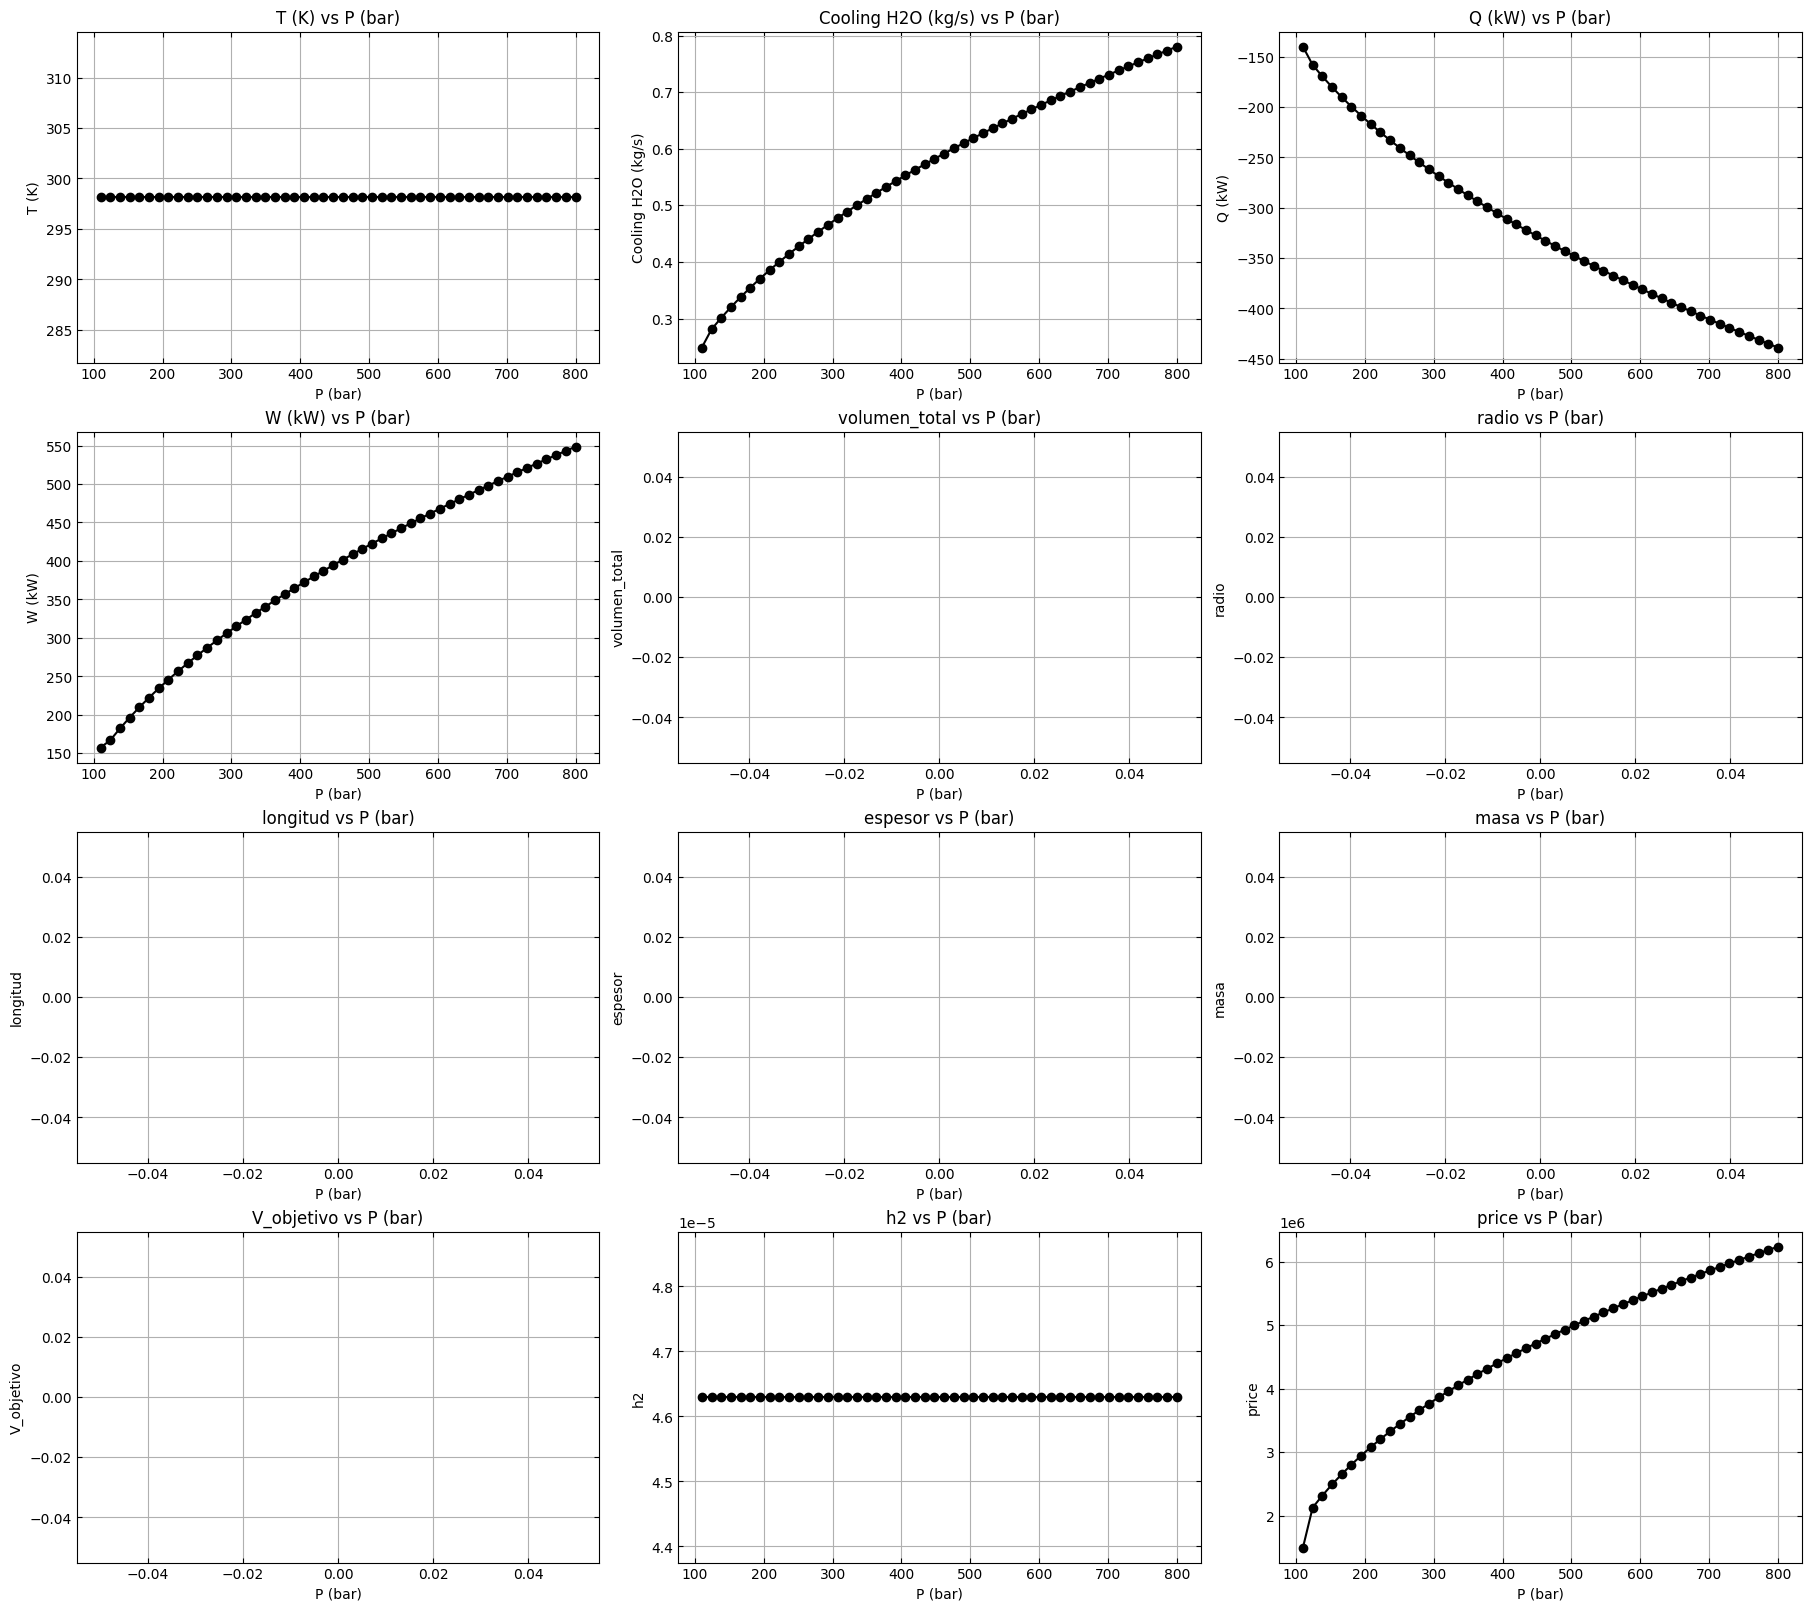

In [13]:
import matplotlib.pyplot as plt
import scienceplots  # Asegúrate de tener instalado: pip install SciencePlots
import math

# Desactivar el uso de LaTeX para evitar el error.
#plt.rcParams['text.usetex'] = False

# Utiliza una combinación de estilos populares para obtener un formato científico
#plt.style.use(['science'])#, 'ieee', 'std-colors'])

# Lista de variables a graficar versus "P (bar)"
variables_to_plot = [
    "T (K)",
    "Cooling H2O (kg/s)",
    "Q (kW)",
    "W (kW)",
    "volumen_total",
    "radio",
    "longitud",
    "espesor",
    "masa",
    "V_objetivo",
    "h2",
    "price"
]

# Se asume que df_resultados ya está definido y contiene la columna "P (bar)" y las demás variables
df_resultados_sorted = df_resultados.sort_values(by="P (bar)")

num_vars = len(variables_to_plot)
cols = 3
rows = math.ceil(num_vars / cols)

fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 4 * rows), constrained_layout=True)
axes = axes.flatten()

# Graficar cada variable versus "P (bar)"
for i, var in enumerate(variables_to_plot):
    ax = axes[i]
    ax.plot(
        df_resultados_sorted["P (bar)"],
        df_resultados_sorted[var],
        marker="o", linestyle="-", color="black"
    )
    ax.set_xlabel("P (bar)")
    ax.set_ylabel(var)
    ax.set_title(f"{var} vs P (bar)")
    ax.grid(True)
    ax.tick_params(axis="both", which="both", direction="in", top=True, right=True)

# Eliminar axes vacíos en caso de que excedan el total de variables
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.show()


In [14]:
df_resultados[df_resultados['price']==df_resultados['price'].min()]['P (bar)']

0    110.0
Name: P (bar), dtype: float64

In [15]:
compis[0]

,Compressor,T (K),P (bar),Cooling H2O (kg/s),Q (kW),W (kW),T comp,Purchased Equipment Cost (USD)
0,No. 1,298.15,70.5,0.158417,-89.123348,104.349276,141.230366,"$250,029.51"
1,No. 2,298.15,110.0,0.090268,-50.783789,53.145488,84.447281,"$129,428.92"
2,Total,298.15,110.0,0.248685,-139.907137,157.494764,225.677647,"$379,458.43"


In [16]:
k=compis[df_resultados['It. No.'][18]]
k['Cooling H2O (kg/d)']=(k['Cooling H2O (kg/s)']*86400)/1e3
k

,Compressor,T (K),P (bar),Cooling H2O (kg/s),Q (kW),W (kW),T comp,Purchased Equipment Cost (USD),Cooling H2O (kg/d)
0,No. 1,298.15,141.823129,0.320744,-180.446699,226.923398,275.935502,"$676,617.99",27.712320
1,No. 2,298.15,252.646259,0.118616,-66.731933,74.436115,108.101803,"$240,971.13",10.248437
2,No. 3,298.15,363.469388,0.082581,-46.459094,47.373660,78.021576,"$153,633.36",7.135012
3,Total,298.15,363.469388,0.521942,-293.637727,348.733173,462.058881,"$1,071,222.49",45.095769


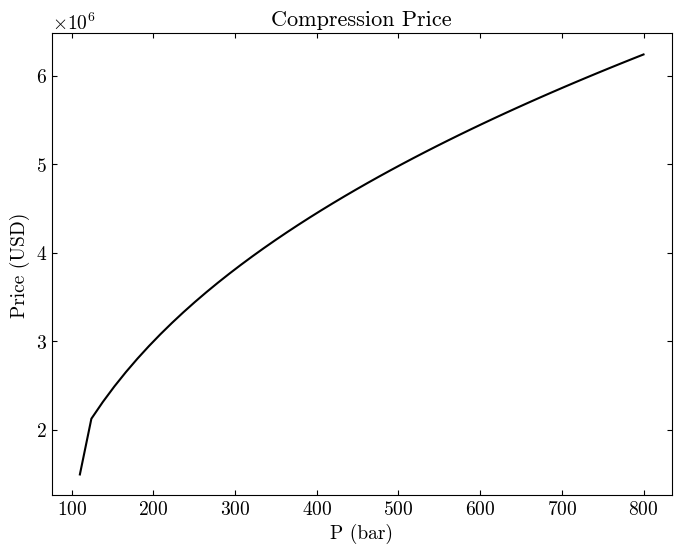

In [17]:
import matplotlib.pyplot as plt
#import scienceplots  # Asegúrate de tener instalado: pip install SciencePlots

# Opcional: activar un estilo popular (en este ejemplo usamos 'no-latex')
plt.style.use(['no-latex'])

# Se asume que df_resultados ya está definido y contiene las columnas "P (bar)" y "price"
df_resultados_sorted = df_resultados.sort_values(by="P (bar)")

# Crear la figura y el eje
fig, ax = plt.subplots(figsize=(8, 6))

# Graficar 'price' en función de 'P (bar)'
ax.plot(df_resultados_sorted["P (bar)"], df_resultados_sorted["price"],
        linestyle="-", color="black",lw=1.5)

# Personalizar etiquetas y título
ax.set_xlabel("P (bar)", fontsize=14)
ax.set_ylabel("Price (USD)", fontsize=14)
ax.set_title("Compression Price", fontsize=16)

# Activar la grilla y ajustar los ticks para un formato profesional

ax.tick_params(axis="both", which="major", labelsize=14, direction="in", top=True, right=True)
ax.tick_params(axis="both", which="minor", labelsize=12, direction="in", top=True, right=True)

# Forzar notación científica (esto hará que se muestre la notación ×10^...)
ax.ticklabel_format(axis="both", style="sci")

# Aumentar el tamaño de la fuente de la notación científica (offset text)
ax.xaxis.get_offset_text().set_fontsize(14)
ax.yaxis.get_offset_text().set_fontsize(14)

plt.show()


In [18]:
import matplotlib.pyplot as plt

# Imprime todos los estilos disponibles en Matplotlib
print(plt.style.available)


['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'bright', 'cjk-jp-font', 'cjk-kr-font', 'cjk-sc-font', 'cjk-tc-font', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'grid', 'high-contrast', 'high-vis', 'ieee', 'latex-sans', 'light', 'muted', 'nature', 'no-latex', 'notebook', 'petroff10', 'pgf', 'retro', 'russian-font', 'sans', 'scatter', 'science', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'std-colors', 'tableau-colorblind10', 'turkish-font', 'vibrant']


Parámetros ajustados:
a = 169763.796244875
n = 0.5418486375296505


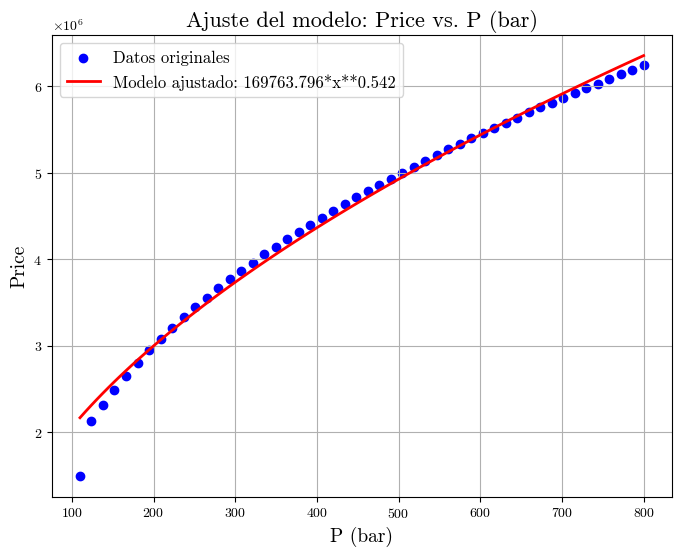

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Se asume que df_resultados ya está definido y contiene las columnas:
# 'P (bar)' -> variable independiente (x)
# 'price'   -> variable dependiente (y)
#
# Si deseas probar con datos simulados, puedes descomentar el siguiente bloque:
# df_resultados = pd.DataFrame({
#     "P (bar)": np.linspace(10, 100, 20),
#     "price": 2.5 * np.linspace(10, 100, 20)**1.2 + np.random.normal(0, 20, 20)
# })

# Extraer los datos
x = df_resultados['P (bar)'].values
y = df_resultados['price'].values

# Definir el modelo: f(x) = a * x^n
def model_func(x, a, n):
    return a * x**n

# Estimar valores iniciales para los parámetros (p0) es muy importante en la optimización no lineal
p0 = [1.0, 1.0]  # a = 1, n = 1, por ejemplo

# Ajuste del modelo usando curve_fit
# Usamos el método 'trf' para que se puedan pasar parámetros de tolerancia (xtol) y max_nfev
popt, pcov = curve_fit(
    model_func, 
    x, 
    y, 
    p0=p0, 
    method='trf', 
    xtol=1e-3,         # Tolerancia en los cambios en la solución 
    max_nfev=10000      # Número máximo de evaluaciones de la función
)

# Los parámetros optimizados se almacenan en popt
a_fit, n_fit = popt

print("Parámetros ajustados:")
print("a =", a_fit)
print("n =", n_fit)

# Crear puntos para graficar el modelo ajustado en el rango de los datos
x_fit = np.linspace(x.min(), x.max(), 100)
y_fit = model_func(x_fit, a_fit, n_fit)

# Graficar los datos originales y la curva ajustada
plt.figure(figsize=(8, 6))
plt.scatter(x, y, label='Datos originales', color='blue')
plt.plot(x_fit, y_fit, label=f'Modelo ajustado: {a_fit:.3f}*x**{n_fit:.3f}', color='red', linewidth=2)
plt.xlabel("P (bar)", fontsize=14)
plt.ylabel("Price", fontsize=14)
plt.title("Ajuste del modelo: Price vs. P (bar)", fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()


Coeficientes ajustados:
a = -5.803003288760666
b = 11153.417128825391
c = 908249.518674652


/home/codespace/.local/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 243 (\N{LATIN SMALL LETTER O WITH ACUTE}) missing from font(s) cmr10.
  fig.canvas.print_figure(bytes_io, **kw)


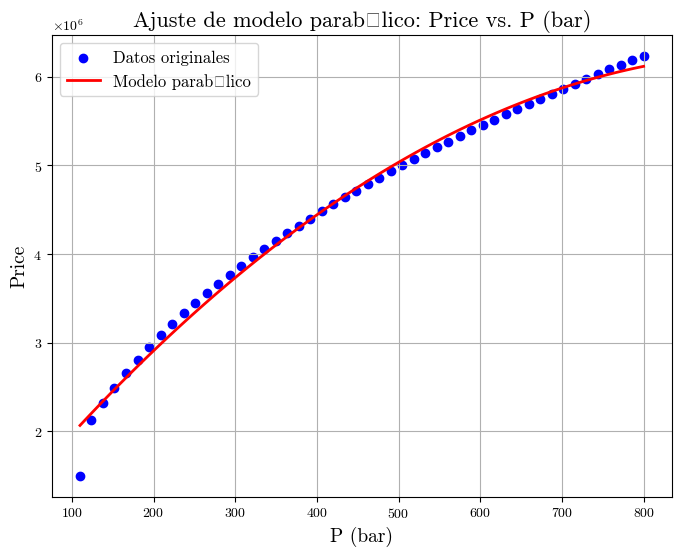

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Supongamos que df_resultados ya está definido y contiene las columnas:
# 'P (bar)' para la presión y 'price' para el costo.
# Ejemplo de datos simulados (comenta o elimina estas líneas al trabajar con tus datos reales)
# df_resultados = pd.DataFrame({
#     "P (bar)": np.linspace(10, 100, 20),
#     "price": 0.05 * np.linspace(10, 100, 20)**2 - 2 * np.linspace(10, 100, 20) + 200 + np.random.normal(0, 20, 20)
# })

# Extraer datos de las columnas de interés
x = df_resultados['P (bar)'].values
y = df_resultados['price'].values

# Ajuste de un polinomio de grado 2 (parábola) a los datos
coeffs = np.polyfit(x, y, 2)  # coeffs = [a, b, c]
fitted_poly = np.poly1d(coeffs)

print("Coeficientes ajustados:")
print("a =", coeffs[0])
print("b =", coeffs[1])
print("c =", coeffs[2])

# Crear puntos para graficar la función ajustada
x_fit = np.linspace(x.min(), x.max(), 100)
y_fit = fitted_poly(x_fit)

# Graficar los datos originales y la curva ajustada
plt.figure(figsize=(8, 6))
plt.scatter(x, y, label='Datos originales', color='blue')
plt.plot(x_fit, y_fit, label='Modelo parabólico', color='red', linewidth=2)
plt.xlabel("P (bar)", fontsize=14)
plt.ylabel("Price", fontsize=14)
plt.title("Ajuste de modelo parabólico: Price vs. P (bar)", fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()


In [21]:
stages,temperature,Qk,Wk,waterr,price=[],[],[],[],[],[]
for i in range(len(Pes)):
    P=Pes[i]
    Po=31
    P_diff=P-Po
    P1=Po
    P2=P
    N_etapas=np.ceil((np.log(P2)/np.log(P1))/np.log(2))
    stages.append(N_etapas)
    P_etapa=P_diff/N_etapas
    Po=Po
    Pf=P
    P_acum=[Po]
    Temps=[25+273.15]
    Tref=Tref
    m=m
    eta=0.75
    Qs,Ts,m_H2O,comp,power,Ps=[],[],[],[],[],[]
    for i in range(int(N_etapas)):
        P1=sum(P_acum)
        print(P1)
        P_acum.append(P_etapa)
        P2=sum(P_acum)
        #Ti=(sum(P_acum)*V2*2)/(m*Z*8.314)
        #print('T',Ti)
        # Valor inicial para la incógnita x (en este caso, es un vector de una dimensión)
        x0 = [1.0]
        sol = root(trabajo_reversible_IT, x0=500, args=(m, P1, P2, eta,298.15), method='hybr')
        if sol.success:
            print(sol.message)
        else:
            print(sol.message)

        resultado = trabajo_reversible(m, P1, P2, eta, sol.x[0]-273.15,298.15)
        print(f"W: {resultado:.20f} kW")
        # Se utiliza scipy.optimize.root con método 'hybr'
        solucion = root(balance, x0, args=(sol.x[0],Tref, m), method='hybr')

        if solucion.success:
            x_encontrado = solucion.x[0]
            print(f"Solución encontrada: x = {x_encontrado:.6f}")
            Temps.append(25+273.15)
            Qs.append(float(-e))
            Ts.append((25+273.15))
            m_H2O.append(float(x_encontrado))
            comp.append('No. '+str(i+1))
            CP=19.67099783 + 0.069681519*T - 0.000200098*T**2 + 2.89493E-07*T**3 - 2.22475E-10*T**4 + 8.81466E-14*T**5 - 1.42043E-17*T**6
            CP=CP/2*1000
            power.append(resultado*1e3)
            Ps.append(P2)
        else:
            print("No se encontró solución:", solucion.message)
    # Crear un DataFrame con los datos
    data = {
        "Compressor": comp,
        "T (K)": Ts,
        "P (bar)": Ps,  # Convertir de Pa a bar
        "Cooling H2O (kg/s)": m_H2O,
        "Q (kW)": np.array(Qs),
        #"Q (kW) Aspen":np.array([-1645.66707374,-775.158866276,-514.144266522]),
        "W (kW)": np.array(power)
        #"W (kW) Aspen":np.array([2211.5522, 1052.84936, 706.504967])
        
    }

    df_compresores = pd.DataFrame(data)

    #df_compresores['Error %']=abs(((df_compresores['Q (kW) Aspen']-df_compresores['Q (kW) Python'])/df_compresores['Q (kW) Aspen']*100 + (df_compresores['W (kW) Aspen']-df_compresores['W (kW) Python'])/df_compresores['W (kW) Aspen']*100)/2)
    df_compresores.loc[df_compresores.shape[0]] = ["Total", Temps[-1], Ps[-1], sum(df_compresores['Cooling H2O (kg/s)']), sum(df_compresores['Q (kW)']), sum(df_compresores['W (kW)'])]
    calculator = PriceCalculator(df_compresores,N_etapas,CS)
    
    
    temperature.append(df_compresores.loc[df_compresores.shape[0]-1]['T (K)'])
    Qk.append(df_compresores.loc[df_compresores.shape[0]-1]['Q (kW)'])
    Wk.append(df_compresores.loc[df_compresores.shape[0]-1]['W (kW)'])
    waterr.append(df_compresores.loc[df_compresores.shape[0]-1]['Cooling H2O (kg/s)'])
    resultadot = calcular_dimension_tanque(P=df_compresores.loc[df_compresores.shape[0]-1]['P (bar)'], m=10000, crit=crit, tipo='hemi', rho_tank=4500)
    
    calculator1 = TankCostCalculator("Type I", resultadot['masa']*1e3)
    price.append(calculator.final+calculator1.final)
    

31
kW 1867.2835333955588
kW 1867.2835333955588
kW 1867.2835333955588
kW 1867.2835483360004
kW 1692.125003213775
kW 1690.4741173340667
kW 1690.4582729397364
kW 1690.4582714369349
The solution converged.
W: 0.10434927601462562485 kW
Solución encontrada: x = 0.158417
70.5
kW 1024.654754246111
kW 1024.654754246111
kW 1024.654754246111
kW 1024.654762370594
kW 862.9168037527157
kW 860.9828037583148
kW 860.9569083348937
kW 860.9569032420858
kW 860.9569032420729
The solution converged.
W: 0.05314548785444894036 kW
Solución encontrada: x = 0.090268
Volumen calculado del tanque: 1830.77 m³
Radio del tanque: 5.59 m
Longitud del tanque: 22.37 m
Espesor del tanque: 447.15 mm
Masa del tanque: 7443.47 ton
31
kW 1574.1256794339677
kW 1574.1256794339677
kW 1574.1256794339677
kW 1574.1256920455478
kW 1389.2961583083168
kW 1387.3212051758812
kW 1387.299170838977
kW 1387.2991679512647
The solution converged.
W: 0.08563575110810273117 kW
Solución encontrada: x = 0.133522
62.027210884353735
kW 930.190343655

/tmp/ipykernel_79139/1972708371.py:62: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_79139/1702185921.py:160: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_79139/1972708371.py:62: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_79139/1702185921.py:160: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_79139/1972708371.py:62: FutureWarning: DataFrame.applymap has been deprecated. 

kW 1027.2179904542832
kW 1027.2179904542731
The solution converged.
W: 0.06340851792927611197 kW
Solución encontrada: x = 0.103935
158.7687074829932
kW 807.9453286106464
kW 807.9453286106464
kW 807.9453286106464
kW 807.9453348324067
kW 671.9512040921936
kW 670.3325314724954
kW 670.3102466940165
kW 670.3102419937599
kW 670.3102419937461
The solution converged.
W: 0.04137717543171271634 kW
Solución encontrada: x = 0.074594
Volumen calculado del tanque: 856.48 m³
Radio del tanque: 4.34 m
Longitud del tanque: 17.36 m
Espesor del tanque: 702.61 mm
Masa del tanque: 4807.28 ton
31
kW 2664.7883548407453
kW 2664.7883548407453
kW 2664.7883548407453
kW 2664.788376057848
kW 2596.2021089721607
kW 2595.973032048265
kW 2595.9722718450334
kW 2595.9722718366907
The solution converged.
W: 0.16024520196522781812 kW
Solución encontrada: x = 0.232647
99.578231292517
kW 1225.365206300626
kW 1225.365206300626
kW 1225.365206300626
kW 1225.365215888445
kW 1052.841095313622
kW 1050.8477895434025
kW 1050.8227653

/tmp/ipykernel_79139/1972708371.py:62: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_79139/1702185921.py:160: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_79139/1972708371.py:62: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_79139/1702185921.py:160: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_79139/1972708371.py:62: FutureWarning: DataFrame.applymap has been deprecated. 

kW 767.453289209107
kW 767.453289209098
The solution converged.
W: 0.04737365982772209078 kW
Solución encontrada: x = 0.082581
Volumen calculado del tanque: 577.18 m³
Radio del tanque: 3.81 m
Longitud del tanque: 15.22 m
Espesor del tanque: 1005.58 mm
Masa del tanque: 4483.43 ton
31
kW 3574.6058854611792
kW 3574.6058854611792
kW 3574.6058854611792
kW 3574.605913670324
kW 3786.5358589164207
kW 3784.3715352267427
kW 3784.3945104136296
kW 3784.394513088495
The solution converged.
W: 0.23360459957336385250 kW
Solución encontrada: x = 0.329530
146.51700680272108
kW 1394.732784657882
kW 1394.732784657882
kW 1394.732784657882
kW 1394.7327953092815
kW 1221.0045546168856
kW 1219.1186549133085
kW 1219.0969690103468
kW 1219.0969659432649
The solution converged.
W: 0.07525289913230027994 kW
Solución encontrada: x = 0.119703
262.03401360544217
kW 916.8253519008626
kW 916.8253519008626
kW 916.8253519008626
kW 916.8253586473393
kW 777.0034251534719
kW 775.4242393009363
kW 775.4040989745525
kW 775.404

/tmp/ipykernel_79139/1972708371.py:62: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_79139/1702185921.py:160: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_79139/1972708371.py:62: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_79139/1702185921.py:160: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_79139/1972708371.py:62: FutureWarning: DataFrame.applymap has been deprecated. 

Volumen calculado del tanque: 451.34 m³
Radio del tanque: 3.51 m
Longitud del tanque: 14.02 m
Espesor del tanque: 1285.36 mm
Masa del tanque: 4594.15 ton
31
kW 4247.963219141102
kW 4247.963219141102
kW 4247.963219141102
kW 4247.963252334954
kW 4789.292722733597
kW 4774.588007191026
kW 4775.032264485424
kW 4775.032707685962
kW 4775.032707672265
The solution converged.
W: 0.29475510541186816793 kW
Solución encontrada: x = 0.409405
193.45578231292515
kW 1501.5178251344046
kW 1501.5178251344046
kW 1501.5178251344046
kW 1501.5178363010948
kW 1331.7297100403066
kW 1330.0046197244017
kW 1329.98636991831
kW 1329.9863677476383
The solution converged.
W: 0.08209792393503939634 kW
Solución encontrada: x = 0.128814
355.9115646258503
kW 987.9328022146607
kW 987.9328022146607
kW 987.9328022146607
kW 987.9328091705302
kW 849.260537880025
kW 847.7814218588886
kW 847.7639038886707
kW 847.7639011536063
The solution converged.
W: 0.05233110500948186944 kW
Solución encontrada: x = 0.089184
Volumen calcula

/tmp/ipykernel_79139/1972708371.py:62: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_79139/1702185921.py:160: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_79139/1972708371.py:62: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_79139/1702185921.py:160: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_79139/1972708371.py:62: FutureWarning: DataFrame.applymap has been deprecated. 

kW 1393.6503685761327
The solution converged.
W: 0.08602780052939090760 kW
Solución encontrada: x = 0.134044
421.6258503401361
kW 1032.4337321229182
kW 1032.4337321229182
kW 1032.4337321229182
kW 1032.4337391676238
kW 895.5237410170008
kW 894.1227155306213
kW 894.1069629419941
kW 894.1069607230907
The solution converged.
W: 0.05519178769895621145 kW
Solución encontrada: x = 0.092993
Volumen calculado del tanque: 391.8 m³
Radio del tanque: 3.34 m
Longitud del tanque: 13.38 m
Espesor del tanque: 1500.06 mm
Masa del tanque: 4819.31 ton
31
kW 4689.684123573196
kW 4689.684123573196
kW 4689.684123573196
kW 4689.684159910394
kW 5507.640585600514
kW 5472.51555065909
kW 5474.275014365205
kW 5474.280039720587
kW 5474.280038972774
The solution converged.
W: 0.33791852092424529141 kW
Solución encontrada: x = 0.464992
231.00680272108843
kW 1569.1446802156818
kW 1569.1446802156818
kW 1569.1446802156818
kW 1569.1446916292405
kW 1403.7839734137042
kW 1402.1933607901353
kW 1402.1776091636043
kW 1402.17

/tmp/ipykernel_79139/1972708371.py:62: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_79139/1702185921.py:160: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_79139/1972708371.py:62: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_79139/1702185921.py:160: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_79139/1972708371.py:62: FutureWarning: DataFrame.applymap has been deprecated. 

Volumen calculado del tanque: 334.43 m³
Radio del tanque: 3.17 m
Longitud del tanque: 12.69 m
Espesor del tanque: 1812.7 mm
Masa del tanque: 5289.69 ton
31
kW 5250.172003649791
kW 5250.172003649791
kW 5250.172003649791
kW 5250.172043788772
kW 6490.651008643647
kW 6403.460291125617
kW 6410.954023183022
kW 6411.0208621543
kW 6411.020807478301
kW 6411.020807478698
The solution converged.
W: 0.39574202515300599403 kW
Solución encontrada: x = 0.537947
287.3333333333333
kW 1656.5589079327071
kW 1656.5589079327071
kW 1656.5589079327071
kW 1656.55891957808
kW 1498.7770244854078
kW 1497.381503574657
kW 1497.3689801618323
kW 1497.3689790988878
The solution converged.
W: 0.09243018389499307874 kW
Solución encontrada: x = 0.142563
543.6666666666666
kW 1110.136598376657
kW 1110.136598376657
kW 1110.136598376657
kW 1110.1366055252772
kW 977.4503423932489
kW 976.1926400114722
kW 976.1797741161764
kW 976.1797726138894
The solution converged.
W: 0.06025801065517835675 kW
Solución encontrada: x = 0.0997

/tmp/ipykernel_79139/1972708371.py:62: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_79139/1702185921.py:160: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)


In [22]:
resultados=pd.DataFrame()
resultados['P (bar)']=Pes
resultados['Stages']=stages
resultados['Q (kW)']=Qk
resultados['W (kW)']=Wk
resultados['H2O (kg/s)']=waterr
resultados['Price (USD)']=price

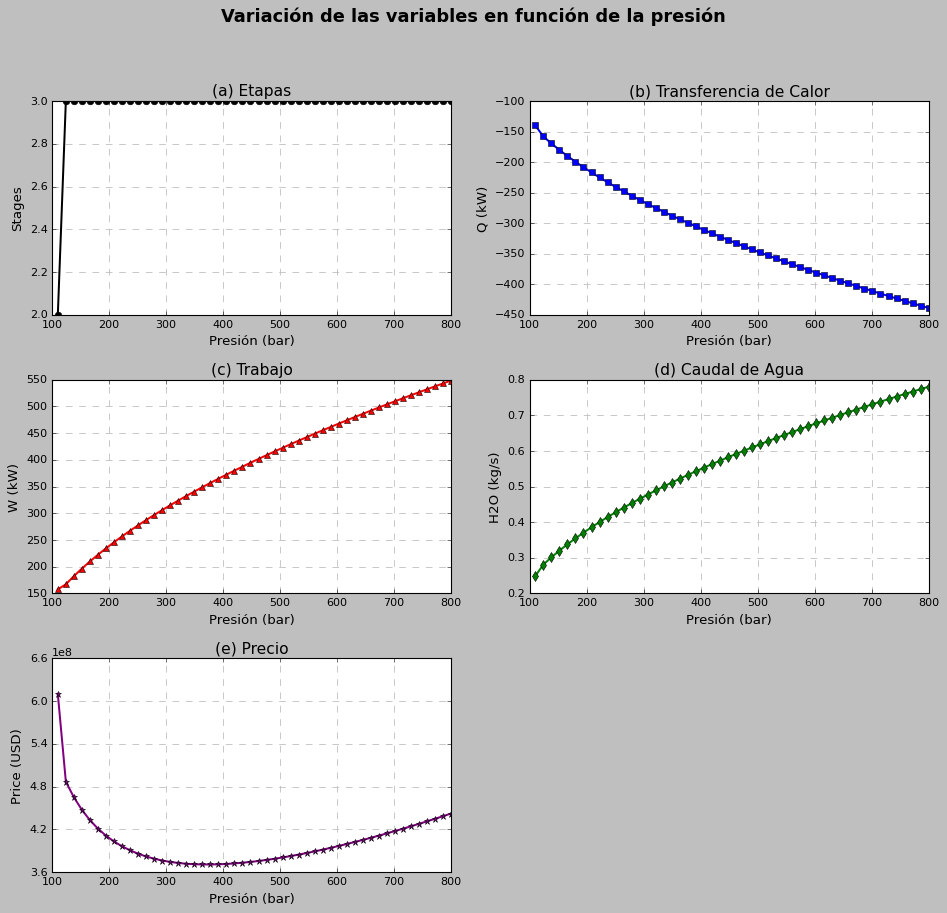

In [23]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.ticker as ticker  # Para controlar la cantidad de ticks en el eje y

# Aplicamos el estilo clásico y actualizamos algunos parámetros estéticos
plt.style.use('classic')
plt.rcParams.update({
    'font.size': 12,             # Tamaño global de fuente
    'axes.labelsize': 12,        # Tamaño de las etiquetas de los ejes
    'axes.titlesize': 14,        # Tamaño de los títulos de los ejes
    'xtick.labelsize': 10,       # Tamaño de las etiquetas del eje x
    'ytick.labelsize': 10,       # Tamaño de las etiquetas del eje y
    'lines.linewidth': 1.8,      # Grosor de las líneas
    'lines.markersize': 6,       # Tamaño de los marcadores
    'grid.linestyle': '--',      # Estilo discontínuo para la rejilla
    'grid.linewidth': 0.75,      # Grosor de la rejilla
    'grid.color': '0.75',        # Color gris para la rejilla
})

# Se asume que las variables Pes, stages, Qk, Wk, waterr y price ya están definidas
resultados = pd.DataFrame({
    'P (bar)': Pes,
    'Stages': stages,
    'Q (kW)': Qk,
    'W (kW)': Wk,
    'H2O (kg/s)': waterr,
    'Price (USD)': price
})

# Configuración de la figura con 3 filas y 2 columnas (sin sharex para mostrar todos los valores en X)
fig, axs = plt.subplots(3, 2, figsize=(12, 12))
fig.suptitle('Variación de las variables en función de la presión', fontsize=16, fontweight='bold')

# Panel (a): Stages vs. Presión
axs[0, 0].plot(resultados['P (bar)'], resultados['Stages'],
               marker='o', linestyle='-', color='black')
axs[0, 0].set_ylabel('Stages')
axs[0, 0].set_title('(a) Etapas')
axs[0, 0].grid(True)
axs[0, 0].set_axisbelow(True)
axs[0, 0].set_xlabel('Presión (bar)')  # Se muestran los valores del eje de la presión

# Panel (b): Q (kW) vs. Presión
axs[0, 1].plot(resultados['P (bar)'], resultados['Q (kW)'],
               marker='s', linestyle='-', color='blue')
axs[0, 1].set_ylabel('Q (kW)')
axs[0, 1].set_title('(b) Transferencia de Calor')
axs[0, 1].grid(True)
axs[0, 1].set_axisbelow(True)
axs[0, 1].set_xlabel('Presión (bar)')

# Panel (c): W (kW) vs. Presión
axs[1, 0].plot(resultados['P (bar)'], resultados['W (kW)'],
               marker='^', linestyle='-', color='red')
axs[1, 0].set_ylabel('W (kW)')
axs[1, 0].set_title('(c) Trabajo')
axs[1, 0].grid(True)
axs[1, 0].set_axisbelow(True)
axs[1, 0].set_xlabel('Presión (bar)')

# Panel (d): H2O (kg/s) vs. Presión
axs[1, 1].plot(resultados['P (bar)'], resultados['H2O (kg/s)'],
               marker='d', linestyle='-', color='green')
axs[1, 1].set_ylabel('H2O (kg/s)')
axs[1, 1].set_title('(d) Caudal de Agua')
axs[1, 1].grid(True)
axs[1, 1].set_axisbelow(True)
axs[1, 1].set_xlabel('Presión (bar)')

# Panel (e): Price (USD) vs. Presión
axs[2, 0].plot(resultados['P (bar)'], resultados['Price (USD)'],
               marker='*', linestyle='-', color='purple')
axs[2, 0].set_ylabel('Price (USD)')
axs[2, 0].set_title('(e) Precio')
axs[2, 0].grid(True)
axs[2, 0].set_axisbelow(True)
axs[2, 0].set_xlabel('Presión (bar)')
# Reducir el número de ticks en el eje y a un máximo de 5 para el gráfico de Price
axs[2, 0].yaxis.set_major_locator(ticker.MaxNLocator(5))

# Ocultamos el panel vacío (última celda de la cuadrícula)
axs[2, 1].axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [24]:


P=172
Po=31
P_diff=P-Po
P1=Po
P2=P
N_etapas=np.ceil((np.log(P2)/np.log(P1))/np.log(2))
N_etapas
P_etapa=P_diff/N_etapas
Po=Po
Pf=P
P_acum=[Po]
Temps=[25+273.15]
Tref=Tref
m=m
eta=0.75
Qs,Ts,m_H2O,comp,power,Ps=[],[],[],[],[],[]
for i in range(int(N_etapas)):
    P1=sum(P_acum)
    print(P1)
    P_acum.append(P_etapa)
    P2=sum(P_acum)
    #Ti=(sum(P_acum)*V2*2)/(m*Z*8.314)
    #print('T',Ti)
    # Valor inicial para la incógnita x (en este caso, es un vector de una dimensión)
    x0 = [1.0]
    sol = root(trabajo_reversible_IT, x0=500, args=(m, P1, P2, eta,298.15), method='hybr')
    if sol.success:
        print(sol.message)
    else:
        print(sol.message)

    resultado = trabajo_reversible(m, P1, P2, eta, sol.x[0]-273.15,298.15)
    print(f"W: {resultado:.20f} kW")
    # Se utiliza scipy.optimize.root con método 'hybr'
    solucion = root(balance, x0, args=(sol.x[0],Tref, m), method='hybr')

    if solucion.success:
        x_encontrado = solucion.x[0]
        print(f"Solución encontrada: x = {x_encontrado:.6f}")
        Temps.append(25+273.15)
        Qs.append(float(-e))
        Ts.append((25+273.15))
        m_H2O.append(float(x_encontrado))
        comp.append('No. '+str(i+1))
        CP=19.67099783 + 0.069681519*T - 0.000200098*T**2 + 2.89493E-07*T**3 - 2.22475E-10*T**4 + 8.81466E-14*T**5 - 1.42043E-17*T**6
        CP=CP/2*1000
        power.append(resultado*1e3)
        Ps.append(P2)
    else:
        print("No se encontró solución:", solucion.message)
# Crear un DataFrame con los datos
data = {
	"Compressor": comp,
    "T (K)": Ts,
    "P (bar)": Ps,  # Convertir de Pa a bar
	"Cooling H2O (kg/s)": m_H2O,
	"Q (kW)": np.array(Qs),
    #"Q (kW) Aspen":np.array([-1645.66707374,-775.158866276,-514.144266522]),
    "W (kW)": np.array(power)
    #"W (kW) Aspen":np.array([2211.5522, 1052.84936, 706.504967])
    
}

df_compresores = pd.DataFrame(data)

#df_compresores['Error %']=abs(((df_compresores['Q (kW) Aspen']-df_compresores['Q (kW) Python'])/df_compresores['Q (kW) Aspen']*100 + (df_compresores['W (kW) Aspen']-df_compresores['W (kW) Python'])/df_compresores['W (kW) Aspen']*100)/2)
df_compresores.loc[df_compresores.shape[0]] = ["Total", Temps[-1], Ps[-1], sum(df_compresores['Cooling H2O (kg/s)']), sum(df_compresores['Q (kW)']), sum(df_compresores['W (kW)'])]
df_compresores


31
kW 2099.6081213396997
kW 2099.6081213396997
kW 2099.6081213396997
kW 2099.6081381186063
kW 1943.0449633545518
kW 1941.7791147680246
kW 1941.7688353379679
kW 1941.768834650278
The solution converged.
W: 0.11986227374384432476 kW
Solución encontrada: x = 0.179040
78.0
kW 1090.4662603714667
kW 1090.4662603714667
kW 1090.4662603714667
kW 1090.4662689896174
kW 924.2422462538713
kW 922.2707260516489
kW 922.2448043895358
kW 922.2447994955525
kW 922.24479949554
The solution converged.
W: 0.05692869132688518213 kW
Solución encontrada: x = 0.095306
125.0
kW 750.7507762999617
kW 750.7507762999617
kW 750.7507762999617
kW 750.7507821595873
kW 619.4312736720176
kW 617.8505447917091
kW 617.8282810823689
kW 617.828276158673
kW 617.8282761586584
The solution converged.
W: 0.03813754791102828834 kW
Solución encontrada: x = 0.070279


,Compressor,T (K),P (bar),Cooling H2O (kg/s),Q (kW),W (kW)
0,No. 1,298.15,78.0,0.179040,-100.725834,119.862274
1,No. 2,298.15,125.0,0.095306,-53.618201,56.928691
2,No. 3,298.15,172.0,0.070279,-39.537813,38.137548
3,Total,298.15,172.0,0.344625,-193.881848,214.928513


In [25]:

calculator = PriceCalculator(df_compresores,N_etapas,CS)

/tmp/ipykernel_79139/1972708371.py:62: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)


In [26]:
calculator.dataframe

,Compressor,T (K),P (bar),Cooling H2O (kg/s),Q (kW),W (kW),Purchased Equipment Cost (USD)
0,No. 1,298.15,78.0,0.179040,-100.725834,119.862274,"$379,742.01"
1,No. 2,298.15,125.0,0.095306,-53.618201,56.928691,"$184,893.71"
2,No. 3,298.15,172.0,0.070279,-39.537813,38.137548,"$122,987.33"
3,Total,298.15,172.0,0.344625,-193.881848,214.928513,"$687,623.05"


In [27]:
Tref

283.15

In [28]:
import numpy as np
import pandas as pd
from scipy.optimize import root, minimize

def normalize_price(price):
    """
    Convierte un valor de precio que puede venir formateado (por ejemplo, "$1,234.56")
    a un número tipo float.
    Si 'price' es un pandas.Series con un solo valor, se extrae ese valor.
    """
    # Si es una serie (con un solo valor), extraer el valor.
    if isinstance(price, pd.Series):
        price = price.iloc[0]
    
    # Si ya es numérico, lo retorna en forma float.
    if isinstance(price, (int, float)):
        return float(price)
    
    if isinstance(price, str):
        # Eliminar símbolos comunes: $, €, espacios y comas
        cleaned = price.replace("$", "").replace("€", "").replace(",", "").strip()
        try:
            return float(cleaned)
        except Exception as ex:
            raise ValueError("No se pudo normalizar el precio: '{}'".format(price))
    # De lo contrario, se intenta convertir a float
    return float(price)

def cost_function(P, m, Tref, T, CS, crit):
    """
    Función objetivo para minimizar; dada una presión P (en bar) calcula el costo total,
    el cual es la suma de:
      - El costo de compresión obtenido con PriceCalculator.
      - El costo del tanque obtenido con TankCostCalculator.
    
    Se normalizan los precios para asegurar que sean float antes de realizar la suma.

    Parámetros:
      - P   : Presión final (en bar). Es la variable independiente a optimizar.
      - m   : Parámetro relacionado a la masa o cantidad a comprimir.
      - Tref: Temperatura de referencia (en Kelvin).
      - T   : Temperatura usada en algunos cálculos (ej. en la ecuación de Cp).
      - CS  : Constante o parámetro requerido por PriceCalculator.
      - crit: Diccionario con las propiedades críticas (keys: 'Tc', 'Pc', 'PM', 'w').
    
    Devuelve:
      total_cost: Suma de los costos (float) de compresión y de tanque.
    """

    # Fijamos la presión de entrada (Po) a 31 bar.
    Po = 31  
    P=P[0]
    if P <= Po:
        # Penalizar fuertemente si la presión final no supera la de entrada.
        return 1e12

    P_diff = P - Po
    P1 = Po
    P2 = P
    # Estimación del número de etapas. Se redondea hacia arriba.
    N_etapas = np.ceil((np.log(P2) / np.log(P1)) / np.log(2))
    # Incremento de presión por etapa:
    P_etapa = P_diff / N_etapas

    # Variables iniciales para las etapas
    P_acum = [Po]            # Acumulador de presión
    Temps = [25 + 273.15]    # Temperatura en Kelvin (25°C + 273.15)
    eta = 0.75               # Eficiencia
    # Inicializar listas para los resultados de cada etapa
    Qs, Ts, m_H2O, comp, power, Ps_list = [], [], [], [], [], []
    
    # Bucle sobre las etapas de compresión:
    for j in range(int(N_etapas)):
        # La presión de entrada actual es la suma de los incrementos acumulados.
        P1_current = sum(P_acum)
        # Agregar la presión de la etapa y actualizar la presión de salida.
        P_acum.append(P_etapa)
        P2_current = sum(P_acum)
        
        # Resolver la ecuación de trabajo reversible (usando una función externa)
        sol = root(trabajo_reversible_IT, x0=500, args=(m, P1_current, P2_current, eta, 298.15), method='hybr')
        if not sol.success:
            return 1e12  # Penalización si no se converge

        # Calcular el trabajo (en kW) usando la función trabajo_reversible.
        # Se utiliza sol.x[0] - 273.15 para convertir de Kelvin a °C.
        resultado = trabajo_reversible(m, P1_current, P2_current, eta, sol.x[0] - 273.15, 298.15)
        
        # Resolver la ecuación de balance (por ejemplo, para obtener el caudal de enfriamiento),
        # usando root con un valor inicial.
        x0_vec = [1.0]
        solucion = root(balance, x0_vec, args=(sol.x[0], Tref, m), method='hybr')
        if not solucion.success:
            return 1e12
        x_encontrado = solucion.x[0]
        
        # Se asume un valor placeholder para "e" (ya que no está definido, se utiliza 0)
        e_value = 0  
        
        # Acumulación de datos para la etapa.
        Temps.append(25 + 273.15)
        Qs.append(float(-e_value))  # Aquí se debe introducir el valor correcto para Q.
        Ts.append(25 + 273.15)
        m_H2O.append(float(x_encontrado))
        comp.append('No. ' + str(j + 1))
        # Se calcula CP con una expresión polinómica (ejemplo, sin utilizarlo directamente)
        CP = (19.67099783 
              + 0.069681519 * T 
              - 0.000200098 * T**2 
              + 2.89493E-07 * T**3 
              - 2.22475E-10 * T**4 
              + 8.81466E-14 * T**5 
              - 1.42043E-17 * T**6)
        CP = CP / 2 * 1000
        
        power.append(resultado * 1e3)  # Convertir a Watts, por ejemplo.
        Ps_list.append(P2_current)
    
    # Armado del DataFrame con información de cada etapa.
    data = {
        "Compressor": comp,
        "T (K)": Ts,
        "P (bar)": Ps_list,  # Se trabaja con P en bar
        "Cooling H2O (kg/s)": m_H2O,
        "Q (kW)": np.array(Qs),
        "W (kW)": np.array(power)
    }
    df_compresores = pd.DataFrame(data)
    # Agregar una fila "Total" que resume los valores.
    total_row = ["Total",
                 Temps[-1],
                 Ps_list[-1],
                 df_compresores["Cooling H2O (kg/s)"].sum(),
                 df_compresores["Q (kW)"].sum(),
                 df_compresores["W (kW)"].sum()]
    df_compresores.loc[df_compresores.shape[0]] = total_row

    # --- Cálculo de costos ---
    # Se obtiene el costo del proceso de compresión.
    calculator = PriceCalculator(df_compresores, N_etapas, CS)
    cost_compression = normalize_price(calculator.final)

    # Se dimensiona el tanque utilizando la función calcular_dimension_tanque.
    resultadot = calcular_dimension_tanque(
        P=sum(Ps_list),
        m=10000,
        crit=crit,
        tipo='hemi',
        rho_tank=4500
    )
    # Se calcula el costo del tanque.
    calculator1 = TankCostCalculator("Type I", resultadot["masa"] * 1e3)
    cost_tank = normalize_price(calculator1.extras_df["Final Cost (USD)"])

    # Sumar ambos costos para obtener el costo total.
    total_cost = cost_compression + cost_tank
    print
    print('TOTAL:',total_cost)
    return total_cost

# --- Ejemplo de optimización usando scipy.minimize ---
if __name__ == '__main__':
    # Parámetros o variables del proceso (se deben definir según tu aplicación)
    m = 4/86400           # Ejemplo: masa o caudal relacionado
    Tref = Tref      # Temperatura de referencia en Kelvin
    T = 298.15         # Temperatura usada para ciertos cálculos (como CP)
    CS = "Carbon Steel"           # Constante para PriceCalculator (ejemplo)
    crit = crit
    
    # Definir límites para la presión óptima (en bar). Po es 31 en el código, así que se debe estar por encima.
    P_min = 50  
    P_max = 1000
    x0 = [900]  # Valor inicial en bar
    
    # Ejecutar la optimización
    res = minimize(cost_function, x0, args=(m, Tref, T, CS, crit),
                   bounds=[(P_min, P_max)])
    
    if res.success:
        print("Presión óptima encontrada (bar):", res.x[0])
        print("Costo total mínimo:", res.fun)
    else:
        print("La optimización falló:", res.message)


kW 5541.063399431749
kW 5541.063399431749
kW 5541.063399431749
kW 5541.0634414469505
kW 7032.575719247068
kW 6900.452524637113
kW 6914.935346060866
kW 6915.153880983119
kW 6915.153488377773
kW 6915.153488388297
kW 1703.815957234465
kW 1703.815957234465
kW 1703.815957234465
kW 1703.8159689704516
kW 1550.800507761304
kW 1549.5135785306297
kW 1549.5026795756426
kW 1549.5026787538607
kW 1151.1566151930156
kW 1151.1566151930156
kW 1151.1566151930156
kW 1151.1566223789655
kW 1021.0558684450076
kW 1019.8721568857829
kW 1019.8606396126753
kW 1019.8606383957296
Volumen calculado del tanque: 2117.63 m³
Radio del tanque: 5.87 m
Longitud del tanque: 23.48 m
Espesor del tanque: 7812.99 mm
Masa del tanque: 100894.15 ton
TOTAL: 8250604482.854986


/tmp/ipykernel_79139/1972708371.py:62: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_79139/1702185921.py:160: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_79139/1972708371.py:62: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_79139/1702185921.py:160: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)


kW 5541.063399459629
kW 5541.063399459629
kW 5541.063399459629
kW 5541.063441474828
kW 7032.575662968159
kW 6900.4525320083
kW 6914.935346325855
kW 6915.153881031335
kW 6915.153488426571
kW 6915.1534884370985
kW 1703.8159572390753
kW 1703.8159572390753
kW 1703.8159572390753
kW 1703.8159689750644
kW 1550.8005037544629
kW 1549.5135785020593
kW 1549.5026795807428
kW 1549.5026787589659
kW 1151.156615197086
kW 1151.156615197086
kW 1151.156615197086
kW 1151.1566223830353
kW 1021.0558693445005
kW 1019.8721568987353
kW 1019.8606396170188
kW 1019.8606384000722
Volumen calculado del tanque: 2117.63 m³
Radio del tanque: 5.87 m
Longitud del tanque: 23.48 m
Espesor del tanque: 7812.99 mm
Masa del tanque: 100894.15 ton
TOTAL: 8250604482.64502
kW 5809.3278402455435
kW 5809.3278402455435
kW 5809.3278402455435
kW 5809.3278839252125
kW 7551.365024359086
kW 7362.413711436898
kW 7387.772223655448
kW 7388.372711056638
kW 7388.370598277902
kW 7388.370598450911
kW 1749.041535057856
kW 1749.041535057856
kW 17

/tmp/ipykernel_79139/1972708371.py:62: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_79139/1702185921.py:160: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_79139/1972708371.py:62: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_79139/1702185921.py:160: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_79139/1972708371.py:62: FutureWarning: DataFrame.applymap has been deprecated. 

Volumen calculado del tanque: 2130.22 m³
Radio del tanque: 5.88 m
Longitud del tanque: 23.52 m
Espesor del tanque: 7909.42 mm
Masa del tanque: 103100.42 ton
TOTAL: 8430909843.91818
kW 5567.362290475074
kW 5567.362290475074
kW 5567.362290475074
kW 5567.362332656319
kW 7082.632458937599
kW 6945.654776461682
kW 6960.985015609835
kW 6961.227126006209
kW 6961.226660383161
kW 6961.226660397139
kW 1708.1746033188656
kW 1708.1746033188656
kW 1708.1746033188656
kW 1708.1746150621736
kW 1555.617412499035
kW 1554.3404683581057
kW 1554.329712967218
kW 1554.3297121652804
kW 1155.0084559148527
kW 1155.0084559148527
kW 1155.0084559148527
kW 1155.008463103857
kW 1025.158841504478
kW 1023.9819415885559
kW 1023.9705441210706
kW 1023.9705429280099
Volumen calculado del tanque: 2130.22 m³
Radio del tanque: 5.88 m
Longitud del tanque: 23.52 m
Espesor del tanque: 7909.42 mm
Masa del tanque: 103100.42 ton
TOTAL: 8430909843.988214
kW 5544.436538282418
kW 5544.436538282418
kW 5544.436538282418
kW 5544.43658031

/tmp/ipykernel_79139/1972708371.py:62: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_79139/1702185921.py:160: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_79139/1972708371.py:62: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_79139/1702185921.py:160: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)


Volumen calculado del tanque: 2119.24 m³
Radio del tanque: 5.87 m
Longitud del tanque: 23.48 m
Espesor del tanque: 7825.31 mm
Masa del tanque: 101174.26 ton
TOTAL: 8273495842.898804
kW 5544.436538310267
kW 5544.436538310267
kW 5544.436538310267
kW 5544.436580346802
kW 7038.9863161842895
kW 6906.248461088251
kW 6920.837657710064
kW 6921.059092568458
kW 6921.058691250958
kW 6921.058691261874
kW 1704.3741434388003
kW 1704.3741434388003
kW 1704.3741434388003
kW 1704.3741551757341
kW 1551.4172192204558
kW 1550.1315701653841
kW 1550.1206896657482
kW 1550.1206888465304
kW 1151.649298431
kW 1151.649298431
kW 1151.649298431
kW 1151.6493056173451
kW 1021.580603215299
kW 1020.3977651748601
kW 1020.3862632991006
kW 1020.3862620852382
Volumen calculado del tanque: 2119.24 m³
Radio del tanque: 5.87 m
Longitud del tanque: 23.48 m
Espesor del tanque: 7825.31 mm
Masa del tanque: 101174.26 ton
TOTAL: 8273495841.848837
kW 5541.249719948423
kW 5541.249719948423
kW 5541.249719948423
kW 5541.249761964798
kW

/tmp/ipykernel_79139/1972708371.py:62: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_79139/1702185921.py:160: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_79139/1972708371.py:62: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_79139/1702185921.py:160: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_79139/1972708371.py:62: FutureWarning: DataFrame.applymap has been deprecated. 

Volumen calculado del tanque: 2117.64 m³
Radio del tanque: 5.87 m
Longitud del tanque: 23.48 m
Espesor del tanque: 7813.07 mm
Masa del tanque: 100895.77 ton
TOTAL: 8250736501.81306
kW 5541.082881522002
kW 5541.082881522002
kW 5541.082881522002
kW 5541.082923537326
kW 7032.612708097492
kW 6900.486002091242
kW 6914.969432400506
kW 6915.187983861219
kW 6915.187591206367
kW 6915.187591216893
kW 1703.819180403105
kW 1703.819180403105
kW 1703.819180403105
kW 1703.8191921390987
kW 1550.804066219265
kW 1549.5171468803658
kW 1549.5062480531512
kW 1549.5062472313873
kW 1151.1594596150194
kW 1151.1594596150194
kW 1151.1594596150194
kW 1151.1594668009723
kW 1021.0588969710211
kW 1019.8751913283072
kW 1019.8636741526198
kW 1019.8636729356938
Volumen calculado del tanque: 2117.64 m³
Radio del tanque: 5.87 m
Longitud del tanque: 23.48 m
Espesor del tanque: 7813.07 mm
Masa del tanque: 100895.77 ton
TOTAL: 8250736501.673094
kW 5541.065417431561
kW 5541.065417431561
kW 5541.065417431561
kW 5541.06545944

/tmp/ipykernel_79139/1702185921.py:160: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_79139/1972708371.py:62: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_79139/1702185921.py:160: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_79139/1972708371.py:62: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_79139/1702185921.py:160: FutureWarning: DataFrame.applymap has been deprecated.

kW 6915.15702083594
kW 1703.8162910973108
kW 1703.8162910973108
kW 1703.8162910973108
kW 1703.8163028332992
kW 1550.8008746074436
kW 1549.5139481333538
kW 1549.5030492062608
kW 1549.5030483844816
kW 1151.1569098241837
kW 1151.1569098241837
kW 1151.1569098241837
kW 1151.156917010134
kW 1021.056181951049
kW 1019.8724711977659
kW 1019.8609539366244
kW 1019.8609527196817
Volumen calculado del tanque: 2117.63 m³
Radio del tanque: 5.87 m
Longitud del tanque: 23.48 m
Espesor del tanque: 7813.0 mm
Masa del tanque: 100894.32 ton
TOTAL: 8250618157.061046
kW 5541.065417459432
kW 5541.065417459432
kW 5541.065417459432
kW 5541.065459474643
kW 7032.57947783018
kW 6900.456001827462
kW 6914.9388771290105
kW 6915.157413483925
kW 6915.157020874204
kW 6915.157020884736
kW 1703.816291101923
kW 1703.816291101923
kW 1703.816291101923
kW 1703.8163028379113
kW 1550.800874977275
kW 1549.513948141522
kW 1549.503049211367
kW 1549.5030483895887
kW 1151.1569098282544
kW 1151.1569098282544
kW 1151.1569098282544
kW 

/tmp/ipykernel_79139/1972708371.py:62: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_79139/1702185921.py:160: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_79139/1972708371.py:62: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_79139/1702185921.py:160: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_79139/1972708371.py:62: FutureWarning: DataFrame.applymap has been deprecated. 

kW 5541.063475087455
kW 5541.063475087455
kW 5541.063475087455
kW 5541.063517102663
kW 7032.575984549488
kW 6900.452638825231
kW 6914.935477962896
kW 6915.154013417601
kW 6915.153620810798
kW 6915.153620821323
kW 1703.81596975113
kW 1703.81596975113
kW 1703.81596975113
kW 1703.8159814871187
kW 1550.8005183414143
kW 1549.5135923605626
kW 1549.502693433253
kW 1549.5026926114756
kW 1151.1566262388665
kW 1151.1566262388665
kW 1151.1566262388665
kW 1151.1566334248166
kW 1021.055879922474
kW 1019.8721686668204
kW 1019.8606513968161
kW 1019.860650179872
Volumen calculado del tanque: 2117.63 m³
Radio del tanque: 5.87 m
Longitud del tanque: 23.48 m
Espesor del tanque: 7812.99 mm
Masa del tanque: 100894.16 ton
TOTAL: 8250604995.936315
kW 5541.063424536532
kW 5541.063424536532
kW 5541.063424536532
kW 5541.063466551731
kW 7032.5757073407685
kW 6900.452575520724
kW 6914.935390213424
kW 6915.153924927729
kW 6915.153532322938
kW 6915.153532333465
kW 1703.815961387861
kW 1703.815961387861
kW 1703.8159

/tmp/ipykernel_79139/1972708371.py:62: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_79139/1702185921.py:160: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_79139/1972708371.py:62: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_79139/1702185921.py:160: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_79139/1972708371.py:62: FutureWarning: DataFrame.applymap has been deprecated. 

kW 1151.156618862423
kW 1151.156618862423
kW 1151.156618862423
kW 1151.156626048374
kW 1021.0558711633818
kW 1019.8721607888891
kW 1019.8606435273382
kW 1019.8606423103962
Volumen calculado del tanque: 2117.63 m³
Radio del tanque: 5.87 m
Longitud del tanque: 23.48 m
Espesor del tanque: 7812.99 mm
Masa del tanque: 100894.15 ton
TOTAL: 8250604653.355326
kW 5541.063404784694
kW 5541.063404784694
kW 5541.063404784694
kW 5541.06344679989
kW 7032.57559728634
kW 6900.452551011889
kW 6914.93535593361
kW 6915.153890351922
kW 6915.153497747931
kW 6915.153497758458
kW 1703.8159581200673
kW 1703.8159581200673
kW 1703.8159581200673
kW 1703.8159698560553
kW 1550.8005065538036
kW 1549.5135794927332
kW 1549.5026805561215
kW 1549.5026797343414
kW 1151.156615974552
kW 1151.156615974552
kW 1151.156615974552
kW 1151.1566231605027
kW 1021.0558683830415
kW 1019.8721577109284
kW 1019.8606404464472
kW 1019.8606392295035
Volumen calculado del tanque: 2117.63 m³
Radio del tanque: 5.87 m
Longitud del tanque: 23.

/tmp/ipykernel_79139/1972708371.py:62: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_79139/1702185921.py:160: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_79139/1972708371.py:62: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_79139/1702185921.py:160: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_79139/1972708371.py:62: FutureWarning: DataFrame.applymap has been deprecated. 

Volumen calculado del tanque: 2117.63 m³
Radio del tanque: 5.87 m
Longitud del tanque: 23.48 m
Espesor del tanque: 7812.99 mm
Masa del tanque: 100894.15 ton
TOTAL: 8250604483.715084
kW 5541.063399540892
kW 5541.063399540892
kW 5541.063399540892
kW 5541.063441556095
kW 7032.575756992351
kW 6900.452519944609
kW 6914.93534610775
kW 6915.153881174558
kW 6915.1534885688225
kW 6915.153488579355
kW 1703.815957252521
kW 1703.815957252521
kW 1703.815957252521
kW 1703.8159689885088
kW 1550.8005059576906
kW 1549.5135785353136
kW 1549.5026795956314
kW 1549.5026787738516
kW 1151.1566152089501
kW 1151.1566152089501
kW 1151.1566152089501
kW 1151.156622394902
kW 1021.0558660749194
kW 1019.87215687982
kW 1019.8606396296701
kW 1019.8606384127304
Volumen calculado del tanque: 2117.63 m³
Radio del tanque: 5.87 m
Longitud del tanque: 23.48 m
Espesor del tanque: 7812.99 mm
Masa del tanque: 100894.15 ton
TOTAL: 8250604483.805118
kW 5541.063399439402
kW 5541.063399439402
kW 5541.063399439402
kW 5541.063441454

/tmp/ipykernel_79139/1972708371.py:62: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_79139/1702185921.py:160: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_79139/1972708371.py:62: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_79139/1702185921.py:160: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_79139/1972708371.py:62: FutureWarning: DataFrame.applymap has been deprecated. 

kW 5541.063399459627
kW 5541.063399459627
kW 5541.063399459627
kW 5541.063441474829
kW 7032.575719296394
kW 6900.45252468548
kW 6914.935346109659
kW 6915.153881031921
kW 6915.153488426571
kW 6915.153488437095
kW 1703.8159572390762
kW 1703.8159572390762
kW 1703.8159572390762
kW 1703.8159689750646
kW 1550.8005048486311
kW 1549.5135785112436
kW 1549.5026795807446
kW 1549.502678758967
kW 1151.156615197086
kW 1151.156615197086
kW 1151.156615197086
kW 1151.1566223830355
kW 1021.0558690461154
kW 1019.8721568958656
kW 1019.8606396170183
kW 1019.8606384000725
Volumen calculado del tanque: 2117.63 m³
Radio del tanque: 5.87 m
Longitud del tanque: 23.48 m
Espesor del tanque: 7812.99 mm
Masa del tanque: 100894.15 ton
TOTAL: 8250604482.64502
kW 5541.063399431846
kW 5541.063399431846
kW 5541.063399431846
kW 5541.063441447049
kW 7032.575738023316
kW 6900.452522196338
kW 6914.9353459889735
kW 6915.153880983486
kW 6915.15348837794
kW 6915.153488388471
kW 1703.8159572344816
kW 1703.8159572344816
kW 1703.

/tmp/ipykernel_79139/1972708371.py:62: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_79139/1702185921.py:160: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_79139/1972708371.py:62: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_79139/1702185921.py:160: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_79139/1972708371.py:62: FutureWarning: DataFrame.applymap has been deprecated. 

Volumen calculado del tanque: 2117.63 m³
Radio del tanque: 5.87 m
Longitud del tanque: 23.48 m
Espesor del tanque: 7812.99 mm
Masa del tanque: 100894.15 ton
TOTAL: 8250604482.854986
kW 5541.063399459629
kW 5541.063399459629
kW 5541.063399459629
kW 5541.063441474828
kW 7032.575662968162
kW 6900.452532008304
kW 6914.935346325857
kW 6915.153881031341
kW 6915.153488426577
kW 6915.153488437099
kW 1703.8159572390755
kW 1703.8159572390755
kW 1703.8159572390755
kW 1703.815968975065
kW 1550.8005030250188
kW 1549.5135784959375
kW 1549.5026795807428
kW 1549.5026787589672
kW 1151.1566151970871
kW 1151.1566151970871
kW 1151.1566151970871
kW 1151.1566223830366
kW 1021.0558690461163
kW 1019.872156895866
kW 1019.8606396170192
kW 1019.8606384000732
Volumen calculado del tanque: 2117.63 m³
Radio del tanque: 5.87 m
Longitud del tanque: 23.48 m
Espesor del tanque: 7812.99 mm
Masa del tanque: 100894.15 ton
TOTAL: 8250604482.64502
kW 5541.063399431798
kW 5541.063399431798
kW 5541.063399431798
kW 5541.063441

/tmp/ipykernel_79139/1702185921.py:160: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_79139/1972708371.py:62: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_79139/1702185921.py:160: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
